## Pre-procesamiento

### 1. Imports y constantes

In [1]:
import os
import sys
import shutil
import typing
import glob

import pandas as pd
import numpy as np

from math import floor
from xml.etree import ElementTree
import collections
import seaborn as sns


In [8]:

RUTA_RDD = "."
CARPETAS_INTERES = ["/China_Drone", "/China_MotorBike", "/Czech", "/India", "/Japan", "/Norway", "/United_States"]
CARPETAS_INTERES = ["/DATA"]
CARPETA_SALIDA = []
RUTA_IMAGENES = "/train/images"
RUTA_ANOTACIONES_ORIGINALES = "/train/annotations/xmls"
# RUTA_ANOTACIONES_SALIDA = f'{RUTA_RDD}/labels_salida'
RUTA_ANOTACIONES_SALIDA = f'{RUTA_RDD}/DATA/labels_salida'
ETIQUETAS_ENTRADA = ["D00","D01","D10","D11","D20","D40","D43","D44", "D50", "Repair"]

### 2. Cantidad de imagenes, chequeo de anotaciones y distribución de etiquetas

Cantidad de imagenes: 5010
Todas las imagenes tienen anotaciones
Background images (cantidad de archivos xml sin etiquetas): 393 (12.75%)
Etiqueta adicional encontrada pero no declarada: BG


c:\Users\enime\miniconda3\envs\object_detection\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


<AxesSubplot: >

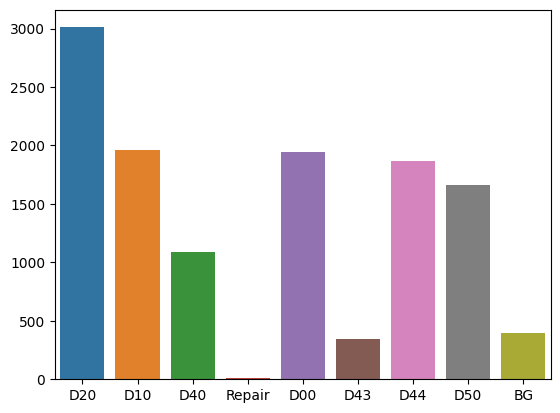

In [9]:
# Mostrar cantidad de imagenes
imagenes_por_pais = {}
rutas_imagenes = []
for pais in CARPETAS_INTERES:
    rutas_imagenes.extend(os.listdir(f'{RUTA_RDD}/{pais}/{RUTA_IMAGENES}'))    
    imagenes_por_pais[pais] = rutas_imagenes

print(f'Cantidad de imagenes: {len(rutas_imagenes)}')

# Chequear existencia de todas las anotaciones
anotaciones = []
ruta_anotacion = ''
for pais in imagenes_por_pais:
    for ruta in imagenes_por_pais[pais]:
        # Chequear que exista la anotacion correspondiente
        archivo_anotacion = '/' + os.path.splitext(ruta)[-2] + ".xml"
        ruta_anotacion = RUTA_RDD + pais + RUTA_ANOTACIONES_ORIGINALES + archivo_anotacion
        if os.path.isfile(ruta_anotacion):
            anotaciones.append(ruta_anotacion)
            
anotaciones_faltantes = len(rutas_imagenes) - len(anotaciones)
if anotaciones_faltantes == 0:
    print("Todas las imagenes tienen anotaciones")
else:
    print(f'Faltan {anotaciones_faltantes} anotaciones')

# Chequear etiquetas declaradas (ETIQUETAS_ENTRADA)
cls_names = []
anotaciones_sin_etiquetas = []
for ruta_anotacion in anotaciones:
    infile_xml = open(ruta_anotacion)
    tree = ElementTree.parse(infile_xml)
    root = tree.getroot()
    
    if root.find('object') is None: 
        anotaciones_sin_etiquetas.append(ruta_anotacion)
        cls_names.append('BG')
        continue
    
    for obj in root.iter('object'):
        cls_name = obj.find('name').text
        cls_names.append(cls_name)
        
    if cls_name == 'D0w0': print(f'revisar ruta {ruta_anotacion}')

porcentaje:float = len(anotaciones) / len(anotaciones_sin_etiquetas)
print(f'Background images (cantidad de archivos xml sin etiquetas): ' + \
    f'{len(anotaciones_sin_etiquetas)} ' + \
    f'({porcentaje:.2f}%)')


count_dict = collections.Counter(cls_names)

for clave in count_dict.keys():
    if clave not in ETIQUETAS_ENTRADA: 
        print(f'Etiqueta adicional encontrada pero no declarada: {clave}')

# Mostrar cantidad de ejemplos de cada etiqueta
cls_dict = {}
for damageType in cls_names:
    cls_dict[damageType] = [count_dict[damageType]]
df = pd.DataFrame.from_dict(cls_dict)

# sns.set_palette("winter", 8)
sns.barplot(df)


### 3. Limpieza

In [10]:
def copiar_xmls(anotaciones):
    # Esta funcion copia los xmls validos
    
    lista = os.listdir(RUTA_ANOTACIONES_SALIDA)
    for elemento in lista:
        if not os.path.isdir(f'{RUTA_ANOTACIONES_SALIDA}/{elemento}'):
            print(f'El directorio de salida no debe contener archivos. Ruta: {RUTA_ANOTACIONES_SALIDA}')
            return
    
    for ruta_anotacion in anotaciones:        
        nombre_archivo = os.path.split(ruta_anotacion)[1]
        ruta_anotacion_destino = f'{RUTA_ANOTACIONES_SALIDA}/{nombre_archivo}'
        shutil.copy(ruta_anotacion, ruta_anotacion_destino)

def generar_txts(anotaciones_sin_etiquetas):
    # Por un lado, se procesan las anotaciones vacias
    for anotacion_vacia in anotaciones_sin_etiquetas:
        nombre_archivo = os.path.split(anotacion_vacia)[1].split(".")[0]
        # Genero txt vacio
        with open(f'{RUTA_ANOTACIONES_SALIDA}/txts/{nombre_archivo}.txt', 'w'): pass
        
    # Por otro, se procesan las anotaciones validas
    ruta_archivo_clases = './classes.txt'
    with open(ruta_archivo_clases, 'w') as file:
        [file.write(f'{clase}\n') for clase in ETIQUETAS_ENTRADA]
    
    print('Ejecutar la siguiente linea en la consola del ambiente:')
    print(f"python XmlToTxt/xmltotxt.py -xml {RUTA_ANOTACIONES_SALIDA} -out {RUTA_ANOTACIONES_SALIDA}/txts -c {ruta_archivo_clases}")
    


In [12]:
anotaciones_validas:list = anotaciones.copy()
[anotaciones_validas.remove(anotacion_invalida) for anotacion_invalida in anotaciones_sin_etiquetas]

copiar_xmls(anotaciones_validas)
generar_txts(anotaciones_sin_etiquetas)

Ejecutar la siguiente linea en la consola del ambiente:
python XmlToTxt/xmltotxt.py -xml ./DATA/labels_salida -out ./DATA/labels_salida/txts -c classes.txt


Hasta acá tenemos los txt como los necesita yolo. Las aumentaciones se pueden hacer desde roboflow

#### 3.1 Funcion para unir clases

#### 3.2 Funcion para quitar clases

#### 3.3 Armo un dataset reducido

In [ ]:
def ruta_imagen_desde_ruta_anotacion(ruta_anotacion:str) -> str:
    RUTA_DATASET_REDUCIDO = 'Japan_reduced'
    _, nombre_archivo = os.path.split(ruta_anotacion)
    nombre_archivo = os.path.splitext(nombre_archivo)[0] + '.jpg'
    ruta_base_destino = os.path.join(RUTA_RDD, RUTA_DATASET_REDUCIDO, RUTA_IMAGENES)
    ruta_imagen_destino = os.path.join(ruta_base_destino, nombre_archivo)
    ruta_base_original = os.path.join(RUTA_RDD, 'Japan', RUTA_IMAGENES)
    ruta_imagen_original = os.path.join(ruta_base_original, nombre_archivo)

    return ruta_imagen_original, ruta_imagen_destino

def muestrear_dataset_desde_etiquetas(factor_escala:float, lista_anotaciones: typing.List[str]):    
    anotaciones_mezcladas = lista_anotaciones.copy()
    np.random.shuffle(anotaciones_mezcladas)
    print(anotaciones_mezcladas[0])
    anotaciones_reducidas = anotaciones_mezcladas[:floor(len(lista_anotaciones)*factor_escala)]
    print(f'Cantidad imagenes en dataset reducido: {len(anotaciones_reducidas)}')
    
    for ruta_anotacion in anotaciones_reducidas:
        ruta_anotacion:str
        ruta_base_anotacion_destino, nombre_archivo = os.path.split(ruta_anotacion)
        ruta_base_anotacion_destino = ruta_base_anotacion_destino.replace('Japan', 'Japan_reduced')
        ruta_anotacion_destino = os.path.join(ruta_base_anotacion_destino, nombre_archivo)
        shutil.copy(ruta_anotacion, ruta_anotacion_destino)
    
        ruta_img_original, ruta_img_destino = ruta_imagen_desde_ruta_anotacion(ruta_anotacion)    
        shutil.copy(ruta_img_original, ruta_img_destino)

In [ ]:

# anotaciones_con_etiquetas = anotaciones.copy()
# [anotaciones_con_etiquetas.remove(anotacion_sin_etiquetas) for anotacion_sin_etiquetas in anotaciones_sin_etiquetas]
# muestrear_dataset_desde_etiquetas(factor_escala=0.15, lista_anotaciones=anotaciones_con_etiquetas)
    

### 4. Generacion de txt para YOLOv5

#### Temporal, extraccion de archivos

In [ ]:
lista_test = ['Japan_001623_jpg.rf.12d99e27e12f572c37b9af32f26ca931.jpg',
 'Japan_000941_jpg.rf.d6c928685e37f7776fa39189d2c66371.jpg',
 'Japan_003412_jpg.rf.b1ff969271f907f597d29f1c64d50f30.jpg',
 'Japan_001785_jpg.rf.51d1a4b4c135a8c640ccb8e076e94d48.jpg',
 'Japan_008863_jpg.rf.c58a9152477446e365b5c0510484fb4c.jpg',
 'Japan_011121_jpg.rf.286522a4da9ca68bb31df9a4af76f872.jpg',
 'Japan_007911_jpg.rf.429f2a3303911db3310c211a8879f716.jpg',
 'Japan_004537_jpg.rf.ac040eeca3c8558c3a5a5219c5a59927.jpg',
 'Japan_004046_jpg.rf.55ceae182efc1786b9249119e4edb593.jpg',
 'Japan_007457_jpg.rf.17b39335dc96aa71f9a1daa052115da8.jpg',
 'Japan_008046_jpg.rf.73ff94eb99c364b7d8dda3a7fe7f4822.jpg',
 'Japan_005263_jpg.rf.4777abab54837a46e3e703f7792a1262.jpg',
 'Japan_011446_jpg.rf.999f65551b17ccb189ff55051f4e2134.jpg',
 'Japan_003063_jpg.rf.d09295b7c96d0770165b8dfa93b16416.jpg',
 'Japan_007308_jpg.rf.f53f75325080b3ebfbab81ba834ffe74.jpg',
 'Japan_006243_jpg.rf.c1a9d24844329338563a3044452b7418.jpg',
 'Japan_007510_jpg.rf.a4e8deb27d726eaab552136e2d1c52c1.jpg',
 'Japan_011253_jpg.rf.35683d86f7ea8b3e8584dada7628d828.jpg',
 'Japan_004623_jpg.rf.c3a7181a2347aaf00c0b97336414a628.jpg',
 'Japan_001061_jpg.rf.30bd4e118e85a083b9fd8c8d7d0729f1.jpg',
 'Japan_010177_jpg.rf.503269026b14be380cb50a59b5de972d.jpg',
 'Japan_011460_jpg.rf.56b03ff276cc40bd0e5ca14c95663830.jpg',
 'Japan_006232_jpg.rf.aa2337d00557de0b173046fbc7895404.jpg',
 'Japan_009528_jpg.rf.d4c8354a7a83b20c6732304be149f94f.jpg',
 'Japan_005895_jpg.rf.99a20d0e63583189aea07456d99245ef.jpg',
 'Japan_000483_jpg.rf.d805df8a20931458bb4e341dce8ac011.jpg',
 'Japan_006423_jpg.rf.436fe0838d84b34afc720765bfda23ed.jpg',
 'Japan_002006_jpg.rf.f7da110e6305af82bb15fa9fbe742e83.jpg',
 'Japan_010197_jpg.rf.a43031d4d88fce7962a93b26b507b7b4.jpg',
 'Japan_010546_jpg.rf.dd2ad3269f51fdb1b403265d8064de8b.jpg',
 'Japan_003865_jpg.rf.1cf9f5063fc5a72b945c52c4bcca8b88.jpg',
 'Japan_004349_jpg.rf.acb949eafbce9fd78a8d57dd4b093519.jpg',
 'Japan_007141_jpg.rf.4ec9f936ec0253a043cbd370d44ef5d1.jpg',
 'Japan_001876_jpg.rf.8e8b754a62bf292cda64da544ae8a3dd.jpg',
 'Japan_003639_jpg.rf.4fece0eda99734b17c381b4a7ee43192.jpg',
 'Japan_005414_jpg.rf.2778d04b9322f3311ad196e58716a589.jpg',
 'Japan_001264_jpg.rf.a002a4024dee4686411f334861c947ad.jpg',
 'Japan_008942_jpg.rf.1a18a239da9a08ccca66aca2d2369b00.jpg',
 'Japan_003033_jpg.rf.a8f0d70d5fc7929b4c52d6d678ed5900.jpg',
 'Japan_003688_jpg.rf.d50213437765abdb04a164295875eda0.jpg',
 'Japan_009660_jpg.rf.d3a2e2219213879f3ccfa41f770f381b.jpg',
 'Japan_012345_jpg.rf.3206010f7c9281916f1de9277889f22b.jpg',
 'Japan_007655_jpg.rf.f63c1d3a5c5b69ff074f5b3c74bb7fe5.jpg',
 'Japan_007006_jpg.rf.f916018fe11f533aefaf234d7f91700f.jpg',
 'Japan_004896_jpg.rf.4102ae34a3377dcee11de8d5ea46eafe.jpg',
 'Japan_009674_jpg.rf.3febfa2d6618c819d22c9ed9381e8d38.jpg',
 'Japan_011577_jpg.rf.73373d659bd40adf63432fbd499d01eb.jpg',
 'Japan_010737_jpg.rf.6b2aa310c83bbce7a2cb5f57382d1c83.jpg',
 'Japan_004044_jpg.rf.40517e302909236e8e94abf0bc67b652.jpg',
 'Japan_003180_jpg.rf.982bf6f821bd1278f2a79fcede441e20.jpg',
 'Japan_000526_jpg.rf.766faba2f8c170f2e4a2366fd2df9af2.jpg',
 'Japan_011439_jpg.rf.e955fe31b8d6b376bbe441aa4963fda4.jpg',
 'Japan_001038_jpg.rf.5aaf5d82c78348bbedf2c1f993e60fb9.jpg',
 'Japan_001830_jpg.rf.52dfa4858b853424ceb295dd53cbce56.jpg',
 'Japan_002118_jpg.rf.53b913e407200df10e398d802684489f.jpg',
 'Japan_011851_jpg.rf.02b310fb8adcb302ca28ea293d20c096.jpg',
 'Japan_009525_jpg.rf.d233d9604d59baab09664065f502b824.jpg',
 'Japan_007289_jpg.rf.45482b38cbcb8009dda6b2545ff31863.jpg',
 'Japan_012057_jpg.rf.f6db80e3bc18c5c1744c3dddb759ef56.jpg',
 'Japan_007783_jpg.rf.c77cfa5e70be76106384ffcb5dae5a11.jpg',
 'Japan_002805_jpg.rf.d8be9d64cd30fbf074229757ba500fcd.jpg',
 'Japan_009492_jpg.rf.24ce6f46ef315987d6547e27a7a8758c.jpg',
 'Japan_009609_jpg.rf.9a21c424dcd42ff01dba8a6087239d92.jpg',
 'Japan_004651_jpg.rf.fe6b3af6a854c8df143a961cdb9af71e.jpg',
 'Japan_011169_jpg.rf.7c5123a3bbdddd2af0ebe98aaf86b43d.jpg',
 'Japan_001301_jpg.rf.ecaccbcbd7fdb20de675c9a37e813c8c.jpg',
 'Japan_006755_jpg.rf.0fa4fff3d17f85c12a0744cc9cc86f58.jpg',
 'Japan_009486_jpg.rf.e8a38b136d3ae09c4fe4a32718e858ce.jpg',
 'Japan_001472_jpg.rf.ebdd5f92ac46a31166f6fac21168f4c2.jpg',
 'Japan_012082_jpg.rf.529fb970a43f51a4f268ffce06927816.jpg',
 'Japan_009965_jpg.rf.2a9ed37d4e6857fc517f670ea1f5314e.jpg',
 'Japan_003466_jpg.rf.df877a2b76be702490035437c9630d09.jpg',
 'Japan_009113_jpg.rf.2ee2813d82e0cfe1e0621dc2336a8bd6.jpg',
 'Japan_004994_jpg.rf.3745b7c2d9500056cba797311db5b48c.jpg',
 'Japan_009749_jpg.rf.ac8dcb612a1efe8f5e9d8c23e05b80ea.jpg',
 'Japan_003608_jpg.rf.3383ccac6660de4ddabc6ddf9a74656d.jpg',
 'Japan_012009_jpg.rf.0d0b05dccffd1266566dc09a286697c9.jpg',
 'Japan_011834_jpg.rf.d0ca232470c5bde16dfeba6b289fe1bd.jpg',
 'Japan_008027_jpg.rf.48e440f86879a609d2d1dff84a82ad1a.jpg',
 'Japan_010333_jpg.rf.19f0cc60b00fe8ca7b47ddc9ebecd798.jpg',
 'Japan_009761_jpg.rf.ab6b24a8e71cb644f21b0269789cae62.jpg',
 'Japan_005471_jpg.rf.32f68d46ac3c3541fbd46e57909e3c63.jpg',
 'Japan_008446_jpg.rf.0b3ca8de8b49f7b2df1b598f6455f9b8.jpg',
 'Japan_012244_jpg.rf.9edc56af234f679ec6ea7ae664093ce6.jpg',
 'Japan_002584_jpg.rf.22a0d83b660447b694c2864f16b64374.jpg',
 'Japan_010209_jpg.rf.f7bfb32ab49d685d0c0455c70156834b.jpg',
 'Japan_002550_jpg.rf.ae276f6ef4d5e05188d2160d13ee1483.jpg',
 'Japan_012610_jpg.rf.16b6ca9b7427d94f1254c3111c6a8be0.jpg',
 'Japan_006057_jpg.rf.43d7d93e83146b381c2811962e6e3594.jpg',
 'Japan_008933_jpg.rf.b1b44a13947a0bf210084110bca3f515.jpg',
 'Japan_005712_jpg.rf.30ef3dd4f26f3711db79255f0cb0f5cf.jpg',
 'Japan_010992_jpg.rf.d99f7a620ec597c85e39fbc64827f4cb.jpg',
 'Japan_007820_jpg.rf.05c95c0d1a648f182f2158aa7e8da1fd.jpg',
 'Japan_008810_jpg.rf.af34b1a5c3c6fccbaa4e0ffaf0082837.jpg',
 'Japan_001184_jpg.rf.aa8e07531c0c7d1da6202d87550f5701.jpg',
 'Japan_004097_jpg.rf.d6d7cade164d0c649561c60c67164a23.jpg',
 'Japan_011461_jpg.rf.323a432fed55239368a104a2f843a3cf.jpg',
 'Japan_005031_jpg.rf.10807516b51d56c901b00e21ea6af30f.jpg',
 'Japan_008113_jpg.rf.a2b007f9b5e02f6fbca4263b45c55e64.jpg',
 'Japan_005502_jpg.rf.c77425a225ef47e0a49d47eb6bbd9020.jpg',
 'Japan_001462_jpg.rf.e74d094125493f67f25c789bd3e8b8d1.jpg',
 'Japan_007225_jpg.rf.ecc956c67a09825ae2eadb4d622a209b.jpg',
 'Japan_000817_jpg.rf.fc87c2ccddc99dfdd8aaf3c4471eeaef.jpg',
 'Japan_009222_jpg.rf.421c9ab4edf1375dd16adac6611237bb.jpg',
 'Japan_009314_jpg.rf.1a38d782d53ab24a8a1273575c72b0fb.jpg',
 'Japan_002937_jpg.rf.12121cfc42b458d5ad7fa2aac593dbf7.jpg',
 'Japan_009040_jpg.rf.5c375c554440beb51bd5d2235b638b31.jpg',
 'Japan_004872_jpg.rf.ceeb003ef45fec8a97a9ae24972e739e.jpg',
 'Japan_008439_jpg.rf.073e933f7d871f4b01632292f012bbc7.jpg',
 'Japan_000508_jpg.rf.437059fed6e93ef8e4efa4d0fefd6fb0.jpg',
 'Japan_011664_jpg.rf.bd2eef6bc31d060bea4dee7b12dcd8ea.jpg',
 'Japan_001489_jpg.rf.6e83693b65980bd0bf5c0af3bfe44ce4.jpg',
 'Japan_004648_jpg.rf.2b4436a5ea08a383786bbc455f19618b.jpg',
 'Japan_007836_jpg.rf.087828d4f5557d1f40cfd9f1d5122e32.jpg',
 'Japan_003554_jpg.rf.caac8d93c4acad32f6c93e30dcfa9dd3.jpg',
 'Japan_005409_jpg.rf.bac58cfb8c7e03f18e42ebdc52fcf93c.jpg',
 'Japan_007053_jpg.rf.6dd0c585c11a0438db5ca6b0e8282ef2.jpg',
 'Japan_000567_jpg.rf.b9fd02ca529426c8733cfd14fe4eb73a.jpg',
 'Japan_007795_jpg.rf.7f88f56323c0557f6e9b964701af76df.jpg',
 'Japan_008249_jpg.rf.0976535a0f9a1072670e40cb22578a3a.jpg',
 'Japan_006802_jpg.rf.e4ea7cea9ebc5a2df43806a647c8212b.jpg',
 'Japan_011759_jpg.rf.1c267688a962916d1bdf5bd4474f390c.jpg',
 'Japan_008836_jpg.rf.4ba768bb0defce1b4db0c66c2b504184.jpg',
 'Japan_004477_jpg.rf.d0b35ba2521f5594ac283f2ffe71a066.jpg',
 'Japan_006292_jpg.rf.8f01125214ee3f5fc5f8d404d70331e1.jpg',
 'Japan_001714_jpg.rf.56f484d1786443bbe2e6bb6113552288.jpg',
 'Japan_007984_jpg.rf.d82448bc807170d911d9a56a8df6a91e.jpg',
 'Japan_004135_jpg.rf.0bfd442dbbf20a67bfa98e9b7c0bb82e.jpg',
 'Japan_003202_jpg.rf.f83db26c72641bbac14c3f44925f6825.jpg',
 'Japan_012634_jpg.rf.6c6ee25e2947d081d465a15368d9a0f5.jpg',
 'Japan_010687_jpg.rf.9c272f71cc6282451691d9c5f7b5dbf0.jpg',
 'Japan_001479_jpg.rf.e90e2bbd41db712f9235c454d6d865e4.jpg',
 'Japan_011292_jpg.rf.cf80e53442a8ea270c0b197c8aa80e0d.jpg',
 'Japan_012463_jpg.rf.9dbf386255b2d5ddd1719b10744c7a0b.jpg',
 'Japan_000983_jpg.rf.703fc24811613bfe0f2e7e23cac6d7a3.jpg',
 'Japan_002750_jpg.rf.6ffa2d3570887b1b6ae26a61a8579651.jpg',
 'Japan_001098_jpg.rf.f8a9a573cabc7abb24d491b34917a68c.jpg',
 'Japan_002976_jpg.rf.66adfdfb4924926bc0fdb0dbcea9f5fd.jpg',
 'Japan_001890_jpg.rf.a28f8fc818c032d5b64ef804fc3873e6.jpg',
 'Japan_009270_jpg.rf.4da3399e3ba403f8185d437033c53af8.jpg',
 'Japan_007651_jpg.rf.a59b958359b2cf9316ee30c15fe3875a.jpg',
 'Japan_011923_jpg.rf.5a9cd7f38f76f42c4c3428a1a7eb854d.jpg',
 'Japan_004403_jpg.rf.e6a90b62012d8316ef16f30bca84dfd3.jpg',
 'Japan_005639_jpg.rf.b3d71b2495f1e0bf4efa0ca8b21f441b.jpg',
 'Japan_005904_jpg.rf.822fa18ecade1ca113339aa03dc57edf.jpg',
 'Japan_012609_jpg.rf.e17bc6ddcbad406f775feddf3c3e7c1e.jpg']

In [ ]:
lista_train = [
    'Japan_001383_jpg.rf.b25e7aeb63a84fa264653d767e6493bd.jpg',
    'Japan_010677_jpg.rf.28204fd71387f5508e73c5a28d6c136e.jpg',
    'Japan_010356_jpg.rf.e1cc7bc437aef894c30af69d7e1a80c8.jpg',
    'Japan_001518_jpg.rf.66a698968842c84f123c3a52585badb2.jpg',
    'Japan_004784_jpg.rf.6a44c6a1a84967e4f8b6684dcec6dc38.jpg',
    'Japan_008425_jpg.rf.280e705ec4074d80555af33e9a08d7c3.jpg',
    'Japan_003396_jpg.rf.8b23b4d5b9d5e5fcde80ba6ce8f816c2.jpg',
    'Japan_005495_jpg.rf.8a720e6d4673b9e75d32b2e6df6b01cc.jpg',
    'Japan_012027_jpg.rf.4e5f38e80a8a3b35987379531c80a1c2.jpg',
    'Japan_009598_jpg.rf.df995bea495162e85f19e04583442695.jpg',
    'Japan_000424_jpg.rf.a77379c91fa5fadfeeb759abcebfbf2c.jpg',
    'Japan_001068_jpg.rf.852ca8e4f7dc4f727137872267c165bf.jpg',
    'Japan_010667_jpg.rf.70cd08b8346923070e5297ccbd5e666a.jpg',
    'Japan_000414_jpg.rf.04e8b61007c1d40c8adc30d12be50ba1.jpg',
    'Japan_002973_jpg.rf.daf99d425f206b4326bc870f31c07497.jpg',
    'Japan_012361_jpg.rf.98187c25a7cc7fa6f5d2c2baf071462f.jpg',
    'Japan_012096_jpg.rf.68ebd3113871bb162c244d35005fa495.jpg',
    'Japan_003424_jpg.rf.50fa52b901bdcfcf56a80da030359695.jpg',
    'Japan_012390_jpg.rf.cb1f1003daebaca1411b44bbb0a827ef.jpg',
    'Japan_003178_jpg.rf.3f88388fd4d72aaf227dcfa649b0e334.jpg',
    'Japan_003757_jpg.rf.44015ebd55ac50a3a23872d8032b323c.jpg',
    'Japan_004856_jpg.rf.4967d3406133742d5e4031f5d98a2e1c.jpg',
    'Japan_002161_jpg.rf.f89dcd2ea75ac89f9296fc5295cccb99.jpg',
    'Japan_005546_jpg.rf.a2b825e827342763efa78d36fcdbd153.jpg',
    'Japan_003627_jpg.rf.1fc0eb178df0d69b6e575c8707ad282d.jpg',
    'Japan_004668_jpg.rf.a56233e276aa3e146fc1f254927be87f.jpg',
    'Japan_004458_jpg.rf.b816607d07b20588e7d698876e05b883.jpg',
    'Japan_009322_jpg.rf.489d9c3c77026141f78ef2ca37df94b8.jpg',
    'Japan_001169_jpg.rf.0d5727d2059e0241b950a7122f4259b1.jpg',
    'Japan_002699_jpg.rf.6c4874d2345e26d7ad9bf61bc7b8df1e.jpg',
    'Japan_010085_jpg.rf.c64d0848e02933b9918b9aae9dfb7f39.jpg',
    'Japan_001773_jpg.rf.11c8dd2019baa57334f6774729ea8d88.jpg',
    'Japan_007083_jpg.rf.61f60b348d9fe70d68afef3ab1c75d0f.jpg',
    'Japan_006386_jpg.rf.161fc284261a4bbbecb03e77f70b9649.jpg',
    'Japan_001822_jpg.rf.3e24706e840ac680b305764761daa4b4.jpg',
    'Japan_005214_jpg.rf.808a69d98f1e36beb882b11b4a307605.jpg',
    'Japan_011860_jpg.rf.f13acd78d0d447a9f15cccefa0ef8923.jpg',
    'Japan_005535_jpg.rf.84b642f270d8252e99164b401d33a1fa.jpg',
    'Japan_011341_jpg.rf.58b1c2666632ab1612169e973034c74c.jpg',
    'Japan_006929_jpg.rf.f5171bf859a6d4bf39179f3616c2b3c9.jpg',
    'Japan_007772_jpg.rf.e56eb808c25f53b4ab8e6de256bc88fb.jpg',
    'Japan_010933_jpg.rf.445480ce17e6fff33025aba1bc91f2ca.jpg',
    'Japan_008229_jpg.rf.0adaa2c43fffb46e1595d5b506a0e9ae.jpg',
    'Japan_000566_jpg.rf.18b39874e7a23dd9d162258d8a976e5e.jpg',
    'Japan_003656_jpg.rf.a7c0eede116d00cfe229de74ab02f100.jpg',
    'Japan_012744_jpg.rf.47ef4225f74dd364a472457ee758335a.jpg',
    'Japan_012184_jpg.rf.ed683c3f6082e40da955b93f266f809e.jpg',
    'Japan_006954_jpg.rf.efb46a1f6bd453a2920a697fe4730e9b.jpg',
    'Japan_011160_jpg.rf.3cb1293b2ce3bf0f2bcb14798300613d.jpg',
    'Japan_008494_jpg.rf.916b16db50ec625a6a15c6b214125c1a.jpg',
    'Japan_012856_jpg.rf.52a08f86ec6394dd23d960f66f1fe165.jpg',
    'Japan_011055_jpg.rf.3aa7b54e64fd214069f7faeb6686e3b2.jpg',
    'Japan_004489_jpg.rf.97cac179742852fa89d92b5eb6ce4587.jpg',
    'Japan_003893_jpg.rf.7946fb8c8f85783e1a9297fb442d2f28.jpg',
    'Japan_007474_jpg.rf.ac830af324041cfccb3c155174f5f478.jpg',
    'Japan_009263_jpg.rf.10b4a01a81b88076062c64a27bdf59fd.jpg',
    'Japan_008219_jpg.rf.26d52d1433a79428ba8c67a0495a3838.jpg',
    'Japan_007745_jpg.rf.e19decd77b98c911e3a238e6a49d3743.jpg',
    'Japan_012358_jpg.rf.2063e4ebc3d8e52a84d7190abc67ca1f.jpg',
    'Japan_002929_jpg.rf.65dbedc062337c3666b5fc966f7bfe66.jpg',
    'Japan_007515_jpg.rf.da432f97be239e2455f17e2c913b21cb.jpg',
    'Japan_009947_jpg.rf.2f2e1c350d9674c7244cff44a027c199.jpg',
    'Japan_010541_jpg.rf.a9fb340b1061143527251930f72f18e4.jpg',
    'Japan_010276_jpg.rf.568191a5c7a2dad53c78f5af5a390417.jpg',
    'Japan_007507_jpg.rf.53792351d652a794d0d033e70d24cc01.jpg',
    'Japan_004235_jpg.rf.fb633d8cbd3c269d41f6159c7929f493.jpg',
    'Japan_002563_jpg.rf.728366e831acfe48bb9a8d5b38429d1f.jpg',
    'Japan_009142_jpg.rf.2bbc3d3771825af58987a0e2dc8288d9.jpg',
    'Japan_003458_jpg.rf.2f08ee9e84d299710ee0133235842137.jpg',
    'Japan_004143_jpg.rf.d2924514989cb04e656915b7e47db655.jpg',
    'Japan_009096_jpg.rf.58276f476b4699c05003462c16cba18f.jpg',
    'Japan_002097_jpg.rf.6d8adc54e8386a340d1b607480ce9f6d.jpg',
    'Japan_007767_jpg.rf.76f0ce352a5aa58ea7d28ed64295bdb2.jpg',
    'Japan_010145_jpg.rf.4960e8e79935f1bda245f70cccab66c2.jpg',
    'Japan_010872_jpg.rf.04076cc1c5389d7ccb3f3117498775e9.jpg',
    'Japan_005396_jpg.rf.2ecd0ea3af6c51f4904a6e9d050cde15.jpg',
    'Japan_009436_jpg.rf.e6af2081958f5997862bba0f63564285.jpg',
    'Japan_000376_jpg.rf.73975f3a55647fea45ff70dd7d0a0ab6.jpg',
    'Japan_009672_jpg.rf.d2a8f4c1b873d7564046636985291992.jpg',
    'Japan_001815_jpg.rf.ee2ba40f7e8e579f3bb12fa345380652.jpg',
    'Japan_000448_jpg.rf.02e3dd9ab32b8449d8f1a76fce8dd3dd.jpg',
    'Japan_003580_jpg.rf.564b6edd4d9972c3265e0d9945cf1cf7.jpg',
    'Japan_012189_jpg.rf.02ff45f984f5c5bf180b7b819e167811.jpg',
    'Japan_005419_jpg.rf.425175845d6edcdf06334828a563118d.jpg',
    'Japan_005733_jpg.rf.c63b4432227ec0c293593df03eb10d2b.jpg',
    'Japan_010143_jpg.rf.d1ea53ddb755d1dc082f3294770a84bb.jpg',
    'Japan_001087_jpg.rf.e64dbc76398430a8c30b7a339cb96b55.jpg',
    'Japan_001015_jpg.rf.2719af970333e4e007e94ea1edeff84c.jpg',
    'Japan_006010_jpg.rf.6848e4c11df4402513d365f2dead8f0b.jpg',
    'Japan_009916_jpg.rf.f56153ff2baf92af31326a850dc8fc72.jpg',
    'Japan_008234_jpg.rf.d87181c2a87a4fa03c7a2962859f0a57.jpg',
    'Japan_005249_jpg.rf.8ad8b6f0889efbea82ac386cbfb8b5e5.jpg',
    'Japan_002111_jpg.rf.2b5ac86f8524da1ef5ea027e8af61216.jpg',
    'Japan_009666_jpg.rf.e5dc27e3bc916c294f99a986e87349f7.jpg',
    'Japan_009353_jpg.rf.7392f6138f5226c486be0b5ef7d869b6.jpg',
    'Japan_010132_jpg.rf.ac6841f680263c92f738a20e8347de7e.jpg',
    'Japan_002501_jpg.rf.bc8306d01e72e5f8d278398258071045.jpg',
    'Japan_005549_jpg.rf.3d107f8aef5c9d24d37e9a06fe45da43.jpg',
    'Japan_011455_jpg.rf.488e61dce0122f415050ed0e9c9a7d3c.jpg',
    'Japan_008364_jpg.rf.6f56f6a28db608afc26ffb91346f28f7.jpg',
    'Japan_012436_jpg.rf.3297a67c21e1a32cbc0621663c5791c3.jpg',
    'Japan_008927_jpg.rf.7d149912ece8485bd552c69a3bd5aaf7.jpg',
    'Japan_012122_jpg.rf.c4a3022868ac2e804a2202fde2b54565.jpg',
    'Japan_002225_jpg.rf.0279f7dd2521a56c6eef6a89378d0ac4.jpg',
    'Japan_010292_jpg.rf.e0b13a5ab121e9537db15126d1999839.jpg',
    'Japan_004363_jpg.rf.79f8dfba75812dc456acb7d8edaf7a77.jpg',
    'Japan_005846_jpg.rf.3a8945f0bbf2d53970ab07dbb7a0a40c.jpg',
    'Japan_005066_jpg.rf.e49dafb81d1e90044c100a679020ce79.jpg',
    'Japan_003402_jpg.rf.31ccc31eb02573ab655421d222050b55.jpg',
    'Japan_011299_jpg.rf.296b3041f83f00f774045baca5f4a127.jpg',
    'Japan_001081_jpg.rf.57f11c3c946e8d3087c7d552d853de8c.jpg',
    'Japan_000984_jpg.rf.5c83e830c5ca2b26455b9455f1290b47.jpg',
    'Japan_009099_jpg.rf.2b4175256e385ec7654a4e22cfbed35e.jpg',
    'Japan_000610_jpg.rf.4aeb6c4db08284750ca5f9c7afae5881.jpg',
    'Japan_011043_jpg.rf.3e2274c89006da51a11539650b2faafa.jpg',
    'Japan_000645_jpg.rf.1e4c08026932ec2705322085ffcb5ddb.jpg',
    'Japan_009900_jpg.rf.4fdfc3ff0bb892d76e4d394622f214e5.jpg',
    'Japan_000531_jpg.rf.6a8aafed433293c8ed3e31252691bd13.jpg',
    'Japan_005828_jpg.rf.13d80c22f8ef4d4277f3bfbaefd1bd39.jpg',
    'Japan_007212_jpg.rf.a3326feff63a612a2eb29667d350242a.jpg',
    'Japan_001409_jpg.rf.8f19da0d39ccea52ce070df5ec59dec9.jpg',
    'Japan_006265_jpg.rf.09dfc3925b47196e4a50a75318467158.jpg',
    'Japan_006192_jpg.rf.f00a34c55cf2f937553293020dca4c4c.jpg',
    'Japan_004219_jpg.rf.a6c8c2d68d4b5181dda2e5c50e353959.jpg',
    'Japan_009547_jpg.rf.23ff1dfe714b4c33dbbe1327be43ce9d.jpg',
    'Japan_002024_jpg.rf.b6bbceb183ce605e7ecf809d0e716533.jpg',
    'Japan_007681_jpg.rf.775d10cc99ee42b73de991d7c91fd6bb.jpg',
    'Japan_004580_jpg.rf.83e37615a920c7c79f42d43f5976851e.jpg',
    'Japan_001174_jpg.rf.ef5f8f949f75c52ed2426d1b7452d0b5.jpg',
    'Japan_003053_jpg.rf.8bbd1bc9d8dce1c58ebf0a31d406930b.jpg',
    'Japan_006457_jpg.rf.f9d9cdf82fcc3b4e9b9c278e475dae14.jpg',
    'Japan_003726_jpg.rf.f0262c262a8c5a91f7f535b890f010b8.jpg',
    'Japan_004657_jpg.rf.ab0c0398e498f5e311e6474677a9d2d6.jpg',
    'Japan_010569_jpg.rf.bb44849e05a6ae11a0cc48b79dd6ea0e.jpg',
    'Japan_001190_jpg.rf.02d38ebec0df3db90e84395c1e7ade39.jpg',
    'Japan_010797_jpg.rf.45c5ad454fc0d20f456aa56178461f99.jpg',
    'Japan_008173_jpg.rf.12beae34b87a4d042fe553e9dfa86883.jpg',
    'Japan_004617_jpg.rf.2909e7a75388583f84a39cce51c8ebaf.jpg',
    'Japan_004323_jpg.rf.97e69944a90748f84f46109115ffe492.jpg',
    'Japan_010486_jpg.rf.1958e22603e446fc53f78b3c32303324.jpg',
    'Japan_007520_jpg.rf.e2932802370d05d8effd78ae91c057c7.jpg',
    'Japan_004208_jpg.rf.0b5f4612d3349be63b42b4d270fe69fc.jpg',
    'Japan_011713_jpg.rf.31faf0ed3d8aab70a7b2866a6e54d559.jpg',
    'Japan_002838_jpg.rf.d2c28c479aaa55b211a776248bec9f42.jpg',
    'Japan_011944_jpg.rf.595985898b63f8443a9ad8a7a924371a.jpg',
    'Japan_012047_jpg.rf.4965b18bcb3b49a3ecb2faded232ac61.jpg',
    'Japan_002473_jpg.rf.238241e311aa3b70de0e6c99a2266e2c.jpg',
    'Japan_004960_jpg.rf.e6db98719e5e8b19f6fbf172d61270c9.jpg',
    'Japan_010311_jpg.rf.f0833e48a7f5a6da06c347ebec663554.jpg',
    'Japan_001121_jpg.rf.e3e8aee1eb07bc3c74060e19b40789bf.jpg',
    'Japan_009580_jpg.rf.2cfcc89e1c85123e07d206482934d756.jpg',
    'Japan_004322_jpg.rf.a90de0ba538eb23e219cf2717de5041c.jpg',
    'Japan_009158_jpg.rf.dc47c41bf9c8d20e1e6e80ebc286ca6f.jpg',
    'Japan_006845_jpg.rf.8399dc9e2e9e3f49695d498e63f15918.jpg',
    'Japan_011212_jpg.rf.2856eca6abe55328423e9dcef3494501.jpg',
    'Japan_002966_jpg.rf.7c6ccd157cf7fcc2af04915cc01b837e.jpg',
    'Japan_005798_jpg.rf.b4b679715e3c0e24eebc1d0ec06e3f07.jpg',
    'Japan_004618_jpg.rf.d075ccc97d9bf73777c015e3fcf204d7.jpg',
    'Japan_004620_jpg.rf.39487a9fc5104097cbd0422eff23f190.jpg',
    'Japan_004604_jpg.rf.b55f2bbef3425d7b5743f24cc3c9048a.jpg',
    'Japan_010756_jpg.rf.53a5af9216c0411c15b7484a58915f36.jpg',
    'Japan_004838_jpg.rf.2f8151e5989dafeadd5c271b08b47831.jpg',
    'Japan_004987_jpg.rf.5b6fb1eacf49984701ffecc076821396.jpg',
    'Japan_012613_jpg.rf.e4da50f03e0c27365be98e0295c0931f.jpg',
    'Japan_009935_jpg.rf.aeac7c4883853762888c73f93e78497a.jpg',
    'Japan_000013_jpg.rf.3b7f0ec5f7414d5f41dbcb6c7727f43b.jpg',
    'Japan_002776_jpg.rf.382c6b22958b9e8b8887844436db2ddb.jpg',
    'Japan_004876_jpg.rf.7759687ed1d1f1a78f4a4373a624816f.jpg',
    'Japan_003267_jpg.rf.508faedf9c94cf0350eb419cfd4abbc8.jpg',
    'Japan_007048_jpg.rf.ef87008cd864c55f827842143042cd3f.jpg',
    'Japan_007727_jpg.rf.1e82df021dffaae533db91c52a674881.jpg',
    'Japan_009415_jpg.rf.7ce537ccf49b15daa99d3fe482e873fd.jpg',
    'Japan_008735_jpg.rf.fc63ad2ab68a8ad82d4fbd0bf73baa58.jpg',
    'Japan_013129_jpg.rf.91e369b7345666fef6b99c509c79d1f2.jpg',
    'Japan_001323_jpg.rf.5145ad25a2bd01747e715f71f9b0528c.jpg',
    'Japan_002902_jpg.rf.0238156a41257ca2d47ca1e47a401feb.jpg',
    'Japan_009885_jpg.rf.d9c49468f16259a3cc1f2d5f7bcbba08.jpg',
    'Japan_004494_jpg.rf.6267e6f22f6a19423db2a2c4d7bf5b73.jpg',
    'Japan_006439_jpg.rf.f6807becdd1ea83e90218f4d57d1505a.jpg',
    'Japan_003187_jpg.rf.b26c5b697abc64ab06f7577aa7fb6ed5.jpg',
    'Japan_003513_jpg.rf.597f76d2570f081f2feae669a5a1618a.jpg',
    'Japan_005766_jpg.rf.524f2a39cdc9559a4b2de11e36147061.jpg',
    'Japan_001755_jpg.rf.9f6bbba6eef159251b706c26b036f4c9.jpg',
    'Japan_006310_jpg.rf.de70dcb834bb5ed10236853e6918b83c.jpg',
    'Japan_005510_jpg.rf.5099c62e410dc161c63e101ca1ca7d3f.jpg',
    'Japan_009425_jpg.rf.9ea673878ec2e0386c970a34ef5f34fd.jpg',
    'Japan_009701_jpg.rf.6261f649ccbce7324f72504c39413bc4.jpg',
    'Japan_004345_jpg.rf.4b224eb9b603480b8ac377980b746477.jpg',
    'Japan_006690_jpg.rf.e92827c23a1e9462efe272f83b4ed604.jpg',
    'Japan_000338_jpg.rf.bf91ec6ac823121a9071eade0beef61b.jpg',
    'Japan_008433_jpg.rf.dce1c6bed0c5f12afd6ae9b5bfb9262e.jpg',
    'Japan_005401_jpg.rf.820bbfa7c60867c5a3b2719ac1f74863.jpg',
    'Japan_004267_jpg.rf.05c3fbbba4cd5edcb352e2927556b8e2.jpg',
    'Japan_009545_jpg.rf.37c349fc186339f7db0322195166c514.jpg',
    'Japan_002125_jpg.rf.cb5deeb7636eaa161f12cb6d8f694d27.jpg',
    'Japan_004491_jpg.rf.2f8a05133005bad17f92fe5ee9565b55.jpg',
    'Japan_004405_jpg.rf.9434b2aa2d868a50851a88c8ec4c2b41.jpg',
    'Japan_005935_jpg.rf.cf1be9c1dfedb5e096c21c4a1a947125.jpg',
    'Japan_001362_jpg.rf.b965ac700bea0064ddbff71f4e058fda.jpg',
    'Japan_005040_jpg.rf.436ee7a34aca088379982f6d773f0d28.jpg',
    'Japan_008727_jpg.rf.0d1916687997fd51398e0f9b0629f769.jpg',
    'Japan_012945_jpg.rf.ae377ad46ac15e0c55b48b2ea08a5208.jpg',
    'Japan_006601_jpg.rf.aa3005e36154deb985ced619652a29e3.jpg',
    'Japan_008450_jpg.rf.36479e39412841e2e1824bd374c41dac.jpg',
    'Japan_006884_jpg.rf.bf6aea2c195074fc6965ab52ed199c1d.jpg',
    'Japan_003895_jpg.rf.4c65d0ba74d42acfbb54d3d48945de8b.jpg',
    'Japan_005241_jpg.rf.3979a2b6ec650dcefdabd702bbe68cbd.jpg',
    'Japan_002404_jpg.rf.2443a0517da48a86b4e3724837c36463.jpg',
    'Japan_009669_jpg.rf.5c86ae778f5241ca5c5a6e80ce364eae.jpg',
    'Japan_003371_jpg.rf.bc4f794b73fdd6e89d458c1597adca8b.jpg',
    'Japan_008029_jpg.rf.d6236880d72e2b4ab99c30004f5ad7e0.jpg',
    'Japan_000935_jpg.rf.cac8c2f3e8b88697bddfc05a33d2e074.jpg',
    'Japan_005299_jpg.rf.ba4d0e784ff0e0bd0e92f6b9b87db0fd.jpg',
    'Japan_000152_jpg.rf.c9312b9d51406ec042d5de1781f1289b.jpg',
    'Japan_004823_jpg.rf.c58242a2b85cad507f50506d74aca562.jpg',
    'Japan_000274_jpg.rf.9e9613923522790bda622366b3bf2bc7.jpg',
    'Japan_006517_jpg.rf.b830a48437c2f7b49f33f20bfaa1fe1a.jpg',
    'Japan_012125_jpg.rf.27df5354ee30c8eb8f0255dcffa4ce4e.jpg',
    'Japan_010903_jpg.rf.5eeb22838e93d94f39efcb4ebaf56497.jpg',
    'Japan_005642_jpg.rf.cc40e72cbaa62813ccf1e802d7759405.jpg',
    'Japan_006619_jpg.rf.d2462801eed1020a3028ded711702f3e.jpg',
    'Japan_003098_jpg.rf.c66eb2f94d90ee82831e6a16b1a81aef.jpg',
    'Japan_008341_jpg.rf.d1a5a9df4dfadade41ae582fc4776691.jpg',
    'Japan_010078_jpg.rf.65192a1a2d7d58b4787fc0d950bcf205.jpg',
    'Japan_006648_jpg.rf.1bb0962c82eb968c97542e7f3d9f760e.jpg',
    'Japan_003633_jpg.rf.8e5d00db6a2085ccb02b64e32e3b656a.jpg',
    'Japan_000530_jpg.rf.e7c61a60687e2d0e1632f82527160fc0.jpg',
    'Japan_009837_jpg.rf.986be6cfd118a84cc48db2511ebb3197.jpg',
    'Japan_002379_jpg.rf.3a6104e4b66be791fdb5748e9550fa5f.jpg',
    'Japan_009973_jpg.rf.5286d4091bc940f3a7d472841dbc1ccb.jpg',
    'Japan_011211_jpg.rf.e0ae7b75f4c1951201ff788500eda1b7.jpg',
    'Japan_008563_jpg.rf.0c8ac927337b47631de1b9acbd3f8a05.jpg',
    'Japan_004171_jpg.rf.6c778f2dec156cc13673e20feac46529.jpg',
    'Japan_010248_jpg.rf.9689bd8ca9b3a39e9a1c0b76d2b7f1db.jpg',
    'Japan_003027_jpg.rf.776dadb5dd76aa4dfaed3ad5d6d290c3.jpg',
    'Japan_004767_jpg.rf.a629c31510d3fa0eadd976e07515f577.jpg',
    'Japan_012888_jpg.rf.8a7e3086203f09110f0067f3987a3810.jpg',
    'Japan_000473_jpg.rf.5e980d924842aff1ebbc7eb558eff29d.jpg',
    'Japan_008236_jpg.rf.d5e5a620747593d9afbb6264765ab510.jpg',
    'Japan_005153_jpg.rf.9b8b95b9813ebe51bfca3d17a62d83e3.jpg',
    'Japan_007214_jpg.rf.ba04969f132ebe5c085fffade11f9d83.jpg',
    'Japan_003629_jpg.rf.91f45be9706d84899a546f40aefb254d.jpg',
    'Japan_012886_jpg.rf.4c4f5c2322ec022e9e1fd492022a3564.jpg',
    'Japan_008509_jpg.rf.c5e8a2e3815a98d01b375de476ca2b2f.jpg',
    'Japan_008769_jpg.rf.3505d1b08806d1e9efb3a7a2fe64b434.jpg',
    'Japan_007368_jpg.rf.041e99a611a41aa8c078e55774bd17c6.jpg',
    'Japan_010188_jpg.rf.fbaab3d70bbe13a77cc471b2d1a1a6ec.jpg',
    'Japan_003494_jpg.rf.6c5365613d6d1e103bf05e1f4b7a1945.jpg',
    'Japan_012521_jpg.rf.5c7b495ce2071310d61921e8e80e13d1.jpg',
    'Japan_011266_jpg.rf.9a7f52106c24ebd146eb0a9c645b9c34.jpg',
    'Japan_011314_jpg.rf.a8be60bf18ae7e7544637665edf9aca2.jpg',
    'Japan_010171_jpg.rf.940d44dfedf0429c95173bdcd56717ba.jpg',
    'Japan_009175_jpg.rf.10c55633e4f19e9df3deb25bfaf8a64f.jpg',
    'Japan_003667_jpg.rf.fd1b5357bbd64bd9601abd461501bb4c.jpg',
    'Japan_008807_jpg.rf.0ade609ac4735cbb81c83f0f5c41deae.jpg',
    'Japan_003253_jpg.rf.cf76f7de15794ae0d0797facf9b7196e.jpg',
    'Japan_001487_jpg.rf.ea78e8e3a2c9fbdd7a24711a5d590945.jpg',
    'Japan_012192_jpg.rf.4c423734f1f3d1fe5cc38b5a6e2cbbc9.jpg',
    'Japan_011518_jpg.rf.7d98d79844d635dab44396f20710620c.jpg',
    'Japan_004394_jpg.rf.66202eaf52f6eaea4f38e9a815bbe6c2.jpg',
    'Japan_007338_jpg.rf.b893b0928e8c8303efd5fc34cf702132.jpg',
    'Japan_010149_jpg.rf.a74ec5ed1eb6a209abc8f66449c1fb63.jpg',
    'Japan_009595_jpg.rf.ab61d6f375f2d43ce5de85ba003f3b56.jpg',
    'Japan_003610_jpg.rf.10519fc3ac11ed5508f1bfce61137286.jpg',
    'Japan_002511_jpg.rf.68a5f4d77768f4cf3120b261e60093dd.jpg',
    'Japan_011671_jpg.rf.c9cb7ec3c5432c608acf6eb709685b3e.jpg',
    'Japan_007688_jpg.rf.623ffbf32e94e96a55ab32f185cf60cb.jpg',
    'Japan_007819_jpg.rf.8adfe17050864739b7106aa7f376b81b.jpg',
    'Japan_007038_jpg.rf.88bc91eb26772f2469adc959c5946542.jpg',
    'Japan_012643_jpg.rf.fdf03841776b9fc0220411d7edb0f4d4.jpg',
    'Japan_008408_jpg.rf.dd842ed664bcb40d39fc24fc1e0af5af.jpg',
    'Japan_007606_jpg.rf.b496132e72e1c2ec1e2f0a6cef86146e.jpg',
    'Japan_003689_jpg.rf.d179f544f3f353ac166dbc362eed8b76.jpg',
    'Japan_007573_jpg.rf.c7f429e365f575250c30b1cac5c92883.jpg',
    'Japan_008690_jpg.rf.3ef014faac7e8bd92e7a80ad8fadd1f2.jpg',
    'Japan_011799_jpg.rf.80a37f5dcd3872d19c7f3b224cd4c14a.jpg',
    'Japan_000930_jpg.rf.9ce14ec6d0a4c005b726d554b24b87aa.jpg',
    'Japan_002897_jpg.rf.b12519a03e851b725180e8b7cc017852.jpg',
    'Japan_011102_jpg.rf.88466836645e09a9e6b158c3844d9a08.jpg',
    'Japan_008644_jpg.rf.51ad596b8836daae1d30bc16232fca91.jpg',
    'Japan_008228_jpg.rf.243a2431b26726aa45912f45e30231bd.jpg',
    'Japan_011815_jpg.rf.613d6fb4a279f0b0a147d08c4a40be91.jpg',
    'Japan_008204_jpg.rf.c177577f705f55a014977c5cab92b205.jpg',
    'Japan_002634_jpg.rf.8c019f8a71cdda15b0efcf93a5376c10.jpg',
    'Japan_009959_jpg.rf.579ab97cb4d93a22b677be8076a6dbef.jpg',
    'Japan_012962_jpg.rf.3b666f36dec8efbf6738823b3ad8fd53.jpg',
    'Japan_003148_jpg.rf.de241e9967f1ba6b6a3659e9c0a89027.jpg',
    'Japan_011361_jpg.rf.968c73def1c0dfc0287cbbab0b598938.jpg',
    'Japan_008824_jpg.rf.dbf97ebc7a6ae9122b52429aaef92413.jpg',
    'Japan_009602_jpg.rf.af0a48d3d8aa2a76867c0dd55a4ebd31.jpg',
    'Japan_007960_jpg.rf.f57c60793b5b94f0f90a20de51c92c33.jpg',
    'Japan_005834_jpg.rf.e6f96ae6ae5cc7664d97d73802e87bff.jpg',
    'Japan_006785_jpg.rf.cdb55334274a66040fa4b885d73cff3c.jpg',
    'Japan_006407_jpg.rf.dd4b8af05593d9753156c22392569510.jpg',
    'Japan_003414_jpg.rf.9ecc7443544a5bafee82f7360426f7bb.jpg',
    'Japan_010505_jpg.rf.9eadf67c42544988bacfaa90f6e88b64.jpg',
    'Japan_008292_jpg.rf.301bb76aa9c813c1b8e4524a6ff95612.jpg',
    'Japan_012453_jpg.rf.662dd89830c61fbd4354ca2582016ece.jpg',
    'Japan_009675_jpg.rf.9606f3e9f8543b423f817765909b1587.jpg',
    'Japan_007725_jpg.rf.b711c6b7287fde78f2bc7c287dfe3de5.jpg',
    'Japan_011375_jpg.rf.6e6a83c2236b694c001d2d206b67686f.jpg',
    'Japan_005095_jpg.rf.a97ea43989c1b2d03285301db2216768.jpg',
    'Japan_005323_jpg.rf.bba1bf9ee0dc125366fa12cedfe06db4.jpg',
    'Japan_005654_jpg.rf.62b8f96201ca5bd0d7d094b6c3a2b7f7.jpg',
    'Japan_003382_jpg.rf.1bafe4d1abe5e67ee8ccbcd73283e364.jpg',
    'Japan_011842_jpg.rf.002fc97f2411b99a20cdf8236dbfc5c1.jpg',
    'Japan_008349_jpg.rf.54c828262a7c32eabf13f1707aaaa509.jpg',
    'Japan_009013_jpg.rf.a739242380b41b8dfe350d03cdc7a271.jpg',
    'Japan_009582_jpg.rf.34a4c022aad4e8fc154d6d3fc797225b.jpg',
    'Japan_002438_jpg.rf.e7405adcd8fd6e5d67b5ef9fc1282d52.jpg',
    'Japan_003167_jpg.rf.7ea4510d999411cd18451baf214c7762.jpg',
    'Japan_012424_jpg.rf.26085c7b305e9a650d6655a52759bd28.jpg',
    'Japan_000926_jpg.rf.31d86c605a6961b5f300ac5eb77e5410.jpg',
    'Japan_005841_jpg.rf.368f43df989646b9f4dccdfb12b0e271.jpg',
    'Japan_006617_jpg.rf.39c12d4a562b12adf56b2eef87da6e22.jpg',
    'Japan_012369_jpg.rf.e3f2037fa291db8a4add994f2726d6bf.jpg',
    'Japan_006687_jpg.rf.0933e93288ab99908c337870111f3f39.jpg',
    'Japan_009143_jpg.rf.bd34311929841c0e29eb7e1bd52de57c.jpg',
    'Japan_008259_jpg.rf.00f035feb67d4225d6cbbaae35054bf3.jpg',
    'Japan_003787_jpg.rf.2655335fa080cbf30682967eff560f2e.jpg',
    'Japan_009877_jpg.rf.05ae23deb69a4e0fd3a526f1eab77ac3.jpg',
    'Japan_009682_jpg.rf.d4fd153367b87a1cbf2a357625af5e42.jpg',
    'Japan_006396_jpg.rf.ddfc42d433ed0dcfa25dac45ef1ab6f5.jpg',
    'Japan_000086_jpg.rf.dd1a1a93990ee37dce3633b356b878b0.jpg',
    'Japan_003777_jpg.rf.f4ae2be51e1d8ef762b68bb103306c2c.jpg',
    'Japan_004297_jpg.rf.81d73c856c9c391b83337425584d2fcb.jpg',
    'Japan_003303_jpg.rf.ac323bb7af1e79a6c887d4dff87b6684.jpg',
    'Japan_012006_jpg.rf.e1470ae38b0274baed2035dd0265882c.jpg',
    'Japan_001559_jpg.rf.8e0a8e3ccc90bc286023b6e969086d2f.jpg',
    'Japan_012675_jpg.rf.755621d15a1c31971bebb22178ede6a0.jpg',
    'Japan_008084_jpg.rf.a969297be3b174bef13512ef16bbf6bb.jpg',
    'Japan_008613_jpg.rf.8a229e8fbeb497f259ccd6ff6c589475.jpg',
    'Japan_012484_jpg.rf.7b673f556c94aae5d8b348fc710e39d2.jpg',
    'Japan_012543_jpg.rf.51c84411b78e592588b6c943fb2782f2.jpg',
    'Japan_001319_jpg.rf.4fb01593e72a766aad8d91b81f7b171a.jpg',
    'Japan_001753_jpg.rf.dc44a91839a1f8f93f67448288ca1f45.jpg',
    'Japan_008956_jpg.rf.53ab5552f544f74b5b0fa72d8d2058e7.jpg',
    'Japan_000742_jpg.rf.698f388b5a740e27f8f407408c5fba6b.jpg',
    'Japan_007126_jpg.rf.338487fe7199734dcafd5ad00eb6064b.jpg',
    'Japan_003137_jpg.rf.99b554132f15c153cb58cb11fdb11374.jpg',
    'Japan_005537_jpg.rf.cce21ca0531ccd014a56cc1be62939a9.jpg',
    'Japan_000971_jpg.rf.18c89a9d8582734e5454e38e423b3bdc.jpg',
    'Japan_008339_jpg.rf.64bfedec0cde775b36eceebe79d08091.jpg',
    'Japan_001667_jpg.rf.48f01d72ee6313197de4650225047d2a.jpg',
    'Japan_007706_jpg.rf.5ce8212488290d311d8c28118172b322.jpg',
    'Japan_001482_jpg.rf.7a616b79770619e1bfde89e75d760935.jpg',
    'Japan_003384_jpg.rf.15e8bccb4538114167f8d13b7c4d1742.jpg',
    'Japan_006330_jpg.rf.43445cc6f9be4a59d259690e02923377.jpg',
    'Japan_005761_jpg.rf.d39a6764a37976250ee77880e5401ea5.jpg',
    'Japan_011988_jpg.rf.f46331f7a4a49cf466b04b282cbcd868.jpg',
    'Japan_010951_jpg.rf.8ecd64fa172ce9c906e1966b2e6e8baa.jpg',
    'Japan_008054_jpg.rf.9a8c21ca33a6e40706c9f6a53b29a828.jpg',
    'Japan_006756_jpg.rf.439c4c6369d34c61b1962e656c41e092.jpg',
    'Japan_009652_jpg.rf.32e4177f3fd6d164d84f538cf2eadde1.jpg',
    'Japan_006504_jpg.rf.504633d0133c24845eb78c12f6c89cd1.jpg',
    'Japan_010126_jpg.rf.49e27c005210b035138036ad1be065c2.jpg',
    'Japan_007739_jpg.rf.ed711e1726299c0057f2fd491d3a81f0.jpg',
    'Japan_003738_jpg.rf.36b808401ae0a681fe2837b98da3606c.jpg',
    'Japan_008970_jpg.rf.33197308c4ba07cffbea20f35288b28d.jpg',
    'Japan_002143_jpg.rf.eebc727ea08a3dfb9c5265821c1e6eff.jpg',
    'Japan_004136_jpg.rf.db8409b541eb0e447e8660f7fccb45b1.jpg',
    'Japan_000388_jpg.rf.120e44dd4c14359f3ff820b49364cebc.jpg',
    'Japan_005041_jpg.rf.b2338226dac3430a497c6d8c1bfda362.jpg',
    'Japan_007736_jpg.rf.4c15f57069238dcaaefc069d7f46f830.jpg',
    'Japan_005271_jpg.rf.f2aa816f60c2d4bd1a157e7443f93ee3.jpg',
    'Japan_002600_jpg.rf.8452cbcb586ce8161c7dd6bdc23a1eb7.jpg',
    'Japan_005106_jpg.rf.926caeb9beab8c94706f5e525bf75fbd.jpg',
    'Japan_003716_jpg.rf.0b2634b3e615016f900ae35df23c6250.jpg',
    'Japan_001735_jpg.rf.ce9271cbcf8a27a0608c620350956d48.jpg',
    'Japan_001707_jpg.rf.fbda38297cb7550fe311a6c41677dac8.jpg',
    'Japan_001249_jpg.rf.b3374ebaeb7937c604d8df58c7e4b9c3.jpg',
    'Japan_004227_jpg.rf.fa4213d56e82e85c3044ec85808fe0c7.jpg',
    'Japan_009052_jpg.rf.ed25f205cac27ebb74f98a5bfa4fa112.jpg',
    'Japan_001836_jpg.rf.4815f93dd196269a9443717c2229adcc.jpg',
    'Japan_000773_jpg.rf.3c32630f1a00f79ac14998e0929978f5.jpg',
    'Japan_005582_jpg.rf.2a1b4fa9104b8f07f741f06189fa51c1.jpg',
    'Japan_005577_jpg.rf.4c85fda7268cde365d09e35338768a95.jpg',
    'Japan_005897_jpg.rf.96fbe69633152d0ac918409d194438c9.jpg',
    'Japan_006650_jpg.rf.4e735b22abbd394aa6e2e1db93ef5034.jpg',
    'Japan_000858_jpg.rf.4254fb595184d9958c98cf0d0de76c60.jpg',
    'Japan_008959_jpg.rf.64e65c0a4cf034d1b6db513242284ed3.jpg',
    'Japan_008209_jpg.rf.4f76df4485385587a24555c74c07352f.jpg',
    'Japan_003479_jpg.rf.84b43172ba0b4c5f5e8f2fceda1f64f2.jpg',
    'Japan_005917_jpg.rf.49ad06e1922dde326720624789fa778b.jpg',
    'Japan_005770_jpg.rf.cf25a14a93444eed1dc3adf482be3874.jpg',
    'Japan_008242_jpg.rf.c154a39e050fd18c0fb103bbebaa528c.jpg',
    'Japan_003233_jpg.rf.084494c4fd1bf3712ea3919ec22c095c.jpg',
    'Japan_001105_jpg.rf.c3657d8459e1c405fbc47cefb6b2bf38.jpg',
    'Japan_001059_jpg.rf.4680e598e7ae074eda4683c94c405d66.jpg',
    'Japan_001669_jpg.rf.25607f56d3677e98c5f59d8c5a6cc927.jpg',
    'Japan_011430_jpg.rf.d157520baa5c30728fde24421b7704b2.jpg',
    'Japan_005566_jpg.rf.cb5fa6fa2e4effa772bc673da0a6f001.jpg',
    'Japan_002908_jpg.rf.16f18fe8890f9cf701e04be6b887a92b.jpg',
    'Japan_009477_jpg.rf.693d18c70bca61b2653a0c83b9620dd7.jpg',
    'Japan_007036_jpg.rf.100234c7031dfd3f945da27fa9b2a4ce.jpg',
    'Japan_003176_jpg.rf.e300233c5672d099947fed4cf5bd308c.jpg',
    'Japan_010007_jpg.rf.31ff1cbb857ccdb2de06ae56c479124e.jpg',
    'Japan_002720_jpg.rf.d31f09cd8f60f953f79df2c66f8fb9f6.jpg',
    'Japan_013054_jpg.rf.c0d2fc9f6d990db431a8d3b7ce133638.jpg',
    'Japan_010665_jpg.rf.b67e318ba0e5feca21b69d9f222eec8b.jpg',
    'Japan_004912_jpg.rf.c44dcae92def520fca6df0d82006fd3e.jpg',
    'Japan_005476_jpg.rf.07651e683da907fa4b317cab81c72533.jpg',
    'Japan_008840_jpg.rf.7adfcc9ab929ad5d0f28dbaa6e75e78c.jpg',
    'Japan_000262_jpg.rf.d30530d4ac0778d124765db98c3f1737.jpg',
    'Japan_007197_jpg.rf.2fd26735da60caf75d6d31afa42f7a1d.jpg',
    'Japan_009400_jpg.rf.cc2f2a8280ce55a99fc63a40c67fda7a.jpg',
    'Japan_002121_jpg.rf.228b799ea7790d4575acad378a3c73bc.jpg',
    'Japan_008975_jpg.rf.6a1a23e549b63fe63757c54cc71b7da8.jpg',
    'Japan_004370_jpg.rf.41cc19d1148ff7752712289fdf2865bf.jpg',
    'Japan_005516_jpg.rf.4fefb56a93f11f8263431d42ed85e8d3.jpg',
    'Japan_000921_jpg.rf.70d518c35405d746684525eda0756ff8.jpg',
    'Japan_013127_jpg.rf.35ee66eebf995940383a91ea7ae361fb.jpg',
    'Japan_006921_jpg.rf.696a9f4d987f52b034eec9865c8f7d51.jpg',
    'Japan_012679_jpg.rf.39519b876ec0119089aca3c2dcd0af81.jpg',
    'Japan_000793_jpg.rf.8d1764867d76529681a7398a10d41a99.jpg',
    'Japan_003693_jpg.rf.e7287497de3ef3d6d480621b70f0a906.jpg',
    'Japan_008056_jpg.rf.2d96ea3aaba9e56d5cda5f838e39b671.jpg',
    'Japan_006722_jpg.rf.4ab49126f50f7af7452632561597a3b4.jpg',
    'Japan_012986_jpg.rf.56710e7bd992d98e02166535021436ca.jpg',
    'Japan_002826_jpg.rf.6bb4db2058142f51c52c5b9e5e184a26.jpg',
    'Japan_000208_jpg.rf.dbf212630b95a92207b818d4107053d4.jpg',
    'Japan_008478_jpg.rf.7180b78784b9a37c502d81fc5c12e4a2.jpg',
    'Japan_003296_jpg.rf.7333258e59a83b685aa0a924e730f291.jpg',
    'Japan_003531_jpg.rf.2c4c1acb8d64daaaded51ff0f1c2e74e.jpg',
    'Japan_000772_jpg.rf.903fb824cddc5c80b581bd47a0aa644b.jpg',
    'Japan_012922_jpg.rf.a56c72adb8506c1790945a93949b794c.jpg',
    'Japan_008327_jpg.rf.9f70ea4bf29a9a19b4d1a2b1985b630d.jpg',
    'Japan_000573_jpg.rf.ae857fc4db978d5d5bd8de84eb77c8b0.jpg',
    'Japan_002025_jpg.rf.6667b652dd6ef84df4d1139e90694c8f.jpg',
    'Japan_011473_jpg.rf.7e5b88604289bca83437d7939e8b1f2d.jpg',
    'Japan_009296_jpg.rf.6dc0c3f7cb1fe0d6c6cb39e9ea70f011.jpg',
    'Japan_009708_jpg.rf.07503ba897d0f3b2e69358882ab77925.jpg',
    'Japan_008342_jpg.rf.643eaddb2ac84459bb057092a0da2b07.jpg',
    'Japan_008590_jpg.rf.65a42404614660ff3da2337af3113a91.jpg',
    'Japan_007926_jpg.rf.ba7754f1871a4ec8c333c70ead7a6355.jpg',
    'Japan_001016_jpg.rf.794f859acefe02472931b0109c48a163.jpg',
    'Japan_008483_jpg.rf.b29d1efacde62e2ec1f3fa99102a148a.jpg',
    'Japan_004819_jpg.rf.4f26e98a7941b00711bb71d5da6a5eff.jpg',
    'Japan_011976_jpg.rf.82398f5fddc8f55b4ce47369b21afb6d.jpg',
    'Japan_012220_jpg.rf.ce1bbfdc7c79e7ffdd51c8fb832bce53.jpg',
    'Japan_012409_jpg.rf.1cbb3c7b1267e055bea88c2893da346d.jpg',
    'Japan_011376_jpg.rf.840e76186929709211c1468e835b294c.jpg',
    'Japan_010870_jpg.rf.e785cbbe532496d08f9a1ebcfbaf2d71.jpg',
    'Japan_010568_jpg.rf.0eccbf0761c582a83d00fffa281110b0.jpg',
    'Japan_010319_jpg.rf.f0a2c595eedc627cc7109e168a37e8b4.jpg',
    'Japan_012277_jpg.rf.95a24f4a8dcd6e0b47d09a4cca7b4fbf.jpg',
    'Japan_000565_jpg.rf.1ce76cd82ef053a888a52fef237121a9.jpg',
    'Japan_005363_jpg.rf.a0c18aba63aae1dd1a8e57b9745cbab5.jpg',
    'Japan_006638_jpg.rf.69cb6a5c48a0936a2191f383cc00ad4a.jpg',
    'Japan_001730_jpg.rf.943bd4854c3fb344ce3c3e5a9127533d.jpg',
    'Japan_003510_jpg.rf.37163792f3994b97133ba2930ba67e5e.jpg',
    'Japan_009241_jpg.rf.86aa8bbdf5f338f16ee7a90ed47c7020.jpg',
    'Japan_010695_jpg.rf.adb757a777fa3b06e6e2a0c0aac526b3.jpg',
    'Japan_010543_jpg.rf.a7ed319db7beb5a365c377286ddce00e.jpg',
    'Japan_012507_jpg.rf.83d2e3c22490b1077650b1398d3e32a0.jpg',
    'Japan_010006_jpg.rf.358c18fa465b9562743138576428dee2.jpg',
    'Japan_001529_jpg.rf.8850ee555edfce996a8e3cf677da9d05.jpg',
    'Japan_007363_jpg.rf.391a19928d85fb2c6516fb85fd352a49.jpg',
    'Japan_001254_jpg.rf.0f671eab78f5471909143d760dd4c9b5.jpg',
    'Japan_008919_jpg.rf.213c1d9c6608bef1878cf4b306d3ad6d.jpg',
    'Japan_003104_jpg.rf.2520f57cccc9d28bf0af8b907f20c818.jpg',
    'Japan_009127_jpg.rf.65682fb716abae4c12550ea7d8aadc61.jpg',
    'Japan_007781_jpg.rf.c40e272e4992623ca4e03103a3805da8.jpg',
    'Japan_004341_jpg.rf.2021f041fc1b4775a4f221d5ad79fe92.jpg',
    'Japan_004112_jpg.rf.1c25376919c1e822e67495bb4a5fa1a5.jpg',
    'Japan_003841_jpg.rf.b68b4f5fecda150ecd68dc5232bb0479.jpg',
    'Japan_007753_jpg.rf.9a15745f5521502e972c670be95e4cfe.jpg',
    'Japan_004959_jpg.rf.e8c338ee7ecd92f1d974e6702e7d8b40.jpg',
    'Japan_007230_jpg.rf.ed468180c8ccd0134f904b29e1efc470.jpg',
    'Japan_003906_jpg.rf.fcc205d20369db05a923b2e891447d60.jpg',
    'Japan_002954_jpg.rf.23a32046b76b2c01baba8bbe6f6ab0cc.jpg',
    'Japan_005011_jpg.rf.ffd6b1dc741ffb63300cd9668ca51e94.jpg',
    'Japan_001245_jpg.rf.4ef1ecd0db786125e6bf174cb88c39ff.jpg',
    'Japan_000851_jpg.rf.63285d150aed87c66b18790cd5ba9c80.jpg',
    'Japan_001484_jpg.rf.8c69cc8dd2167b134ebdbc2fc6b73ad9.jpg',
    'Japan_006976_jpg.rf.05ace5b30c3f21b447f9c7348413ca82.jpg',
    'Japan_000150_jpg.rf.c877ed1a3da43f70a80a10da3e252967.jpg',
    'Japan_002248_jpg.rf.264bf6c97aa96036cc9f731a31b20311.jpg',
    'Japan_008618_jpg.rf.256908d8d95db6333346b4be87819396.jpg',
    'Japan_006221_jpg.rf.ba27fff7735ca613be68d6f5b55eafe0.jpg',
    'Japan_006356_jpg.rf.806c1c349222a0f185488d2e186ed4d5.jpg',
    'Japan_001140_jpg.rf.301602e63a6e5d9b86e25e76b7940ea0.jpg',
    'Japan_008545_jpg.rf.f4871e4117cc641567f716288653fb73.jpg',
    'Japan_007101_jpg.rf.ec662abdb03107313fe291250613e20d.jpg',
    'Japan_007354_jpg.rf.448c8a04a5f27e8536ff0f4161d8c36f.jpg',
    'Japan_001467_jpg.rf.c89535d4f6a8720370495ab873790c13.jpg',
    'Japan_012970_jpg.rf.ba4a715bf921563aa2239147a3389a09.jpg',
    'Japan_013035_jpg.rf.d1c5e6b17536907a73c7e33ecc0c1bdb.jpg',
    'Japan_010670_jpg.rf.1878ddeb005e1a45d790e4a6dc933a55.jpg',
    'Japan_011274_jpg.rf.5add11e7dc9ccaeb2835f0f3ebcdcd33.jpg',
    'Japan_009927_jpg.rf.1500a7b63830d1c035b1158da690dd73.jpg',
    'Japan_012660_jpg.rf.0b0607841c24a6d6338394d5ce5ae731.jpg',
    'Japan_007776_jpg.rf.8e8fb94570b3ab22639b6b2f96e696c2.jpg',
    'Japan_002389_jpg.rf.f0383a864b7caf22118ab8b6d49db1fe.jpg',
    'Japan_005644_jpg.rf.c634408d04126f606924910a955ed756.jpg',
    'Japan_011731_jpg.rf.0d23d7512918e8f50d901cf6397c962c.jpg',
    'Japan_011698_jpg.rf.312bd252bd7f9ac07777b35fe7c40061.jpg',
    'Japan_006424_jpg.rf.90a940da1b8c1212727e71d596db24c8.jpg',
    'Japan_011241_jpg.rf.588a9fddffb0f303ab778e2e936bd3bc.jpg',
    'Japan_006903_jpg.rf.b533de5a3906a9e23e1d65dd31841760.jpg',
    'Japan_010236_jpg.rf.376b341642c9d4a3899920685bb3041a.jpg',
    'Japan_003238_jpg.rf.a15d15f3a08447a8eeeacb2a880ce856.jpg',
    'Japan_001524_jpg.rf.e270aeb3958b0871d7d4f868d5d0c82a.jpg',
    'Japan_008352_jpg.rf.eb7386186ad925d1ae6b5746f6df9f38.jpg',
    'Japan_010109_jpg.rf.be7bfe57f880cd0e51fb17e3518e692b.jpg',
    'Japan_011291_jpg.rf.afaa847b94394bd1f3a2b112b6678820.jpg',
    'Japan_008197_jpg.rf.97d69705ecd997eba3498e65c8b53f6c.jpg',
    'Japan_003482_jpg.rf.28216fa21487994ce412a8d3d5629ad6.jpg',
    'Japan_010022_jpg.rf.6a072904063604e3fc7555e53821b547.jpg',
    'Japan_007876_jpg.rf.a2519ebacff32b8c9675d1ccbc342440.jpg',
    'Japan_008260_jpg.rf.0368e52545a93fb48a1a8e795f2fa727.jpg',
    'Japan_005947_jpg.rf.9cc418159e7ebdc6d30ee843b33d1d26.jpg',
    'Japan_001975_jpg.rf.2b7e9555124f5b076f8b7bd94023e5b4.jpg',
    'Japan_003965_jpg.rf.fe4ccc233e6ee859cf5d6f062499dde7.jpg',
    'Japan_001992_jpg.rf.596d354d064bcd6aa5a4baeaba062c49.jpg',
    'Japan_006932_jpg.rf.82b261ae6092977c6f01f719e24a8129.jpg',
    'Japan_010200_jpg.rf.4da44d69a2a4e5d496fa0d1195cb7554.jpg',
    'Japan_002311_jpg.rf.8a696040dae1aa217037596e1f33197b.jpg',
    'Japan_002425_jpg.rf.561ecbb395d7d8dcd2b2f4a062ce5496.jpg',
    'Japan_004075_jpg.rf.06d413145b9c83be25f2b2585f70b411.jpg',
    'Japan_004083_jpg.rf.58bc84d4df096fc6d5c9fb88a5833130.jpg',
    'Japan_007752_jpg.rf.8f1d0a04b5f5f7f1ab529962900b70e8.jpg',
    'Japan_011449_jpg.rf.561b180cb56a0356b01ce6ffe57faa6a.jpg',
    'Japan_001905_jpg.rf.f83c62ced97830d388db105712a732a7.jpg',
    'Japan_004756_jpg.rf.6793a183a57fbb9d06e05cb68c3bf67b.jpg',
    'Japan_011306_jpg.rf.1ddb3c45623bd75741483398208931ce.jpg',
    'Japan_001582_jpg.rf.da9e133aa8824e2b042f763d6a7b4ede.jpg',
    'Japan_011140_jpg.rf.40381c794479938898ca522d7c33ebbf.jpg',
    'Japan_007079_jpg.rf.d42503c438ae9a719767308d3ac20d7d.jpg',
    'Japan_013120_jpg.rf.030d97ad202babf5f09a7efa30116bfb.jpg',
    'Japan_002349_jpg.rf.10044a26cfc15a507f49cf4fce3e543c.jpg',
    'Japan_012297_jpg.rf.0edba1bc95aaa15b2709882cf7d68d70.jpg',
    'Japan_005488_jpg.rf.8bfd9cfc5cb4e4ea992cc37a37a0534d.jpg',
    'Japan_005609_jpg.rf.01217748a334f9d98ca09e4111a1263e.jpg',
    'Japan_006934_jpg.rf.340e1e947669c5b8fe60d92cd4bc1645.jpg',
    'Japan_005330_jpg.rf.f0e037bd563996cec2138ddc742b20d5.jpg',
    'Japan_010919_jpg.rf.dee63c0129e40f324e9c59d3aebf3378.jpg',
    'Japan_000503_jpg.rf.dd9e55798e95862aa326511b9f78b9ce.jpg',
    'Japan_007807_jpg.rf.ce816c9caf7698864f0991d4fb5154f9.jpg',
    'Japan_003228_jpg.rf.58110a78554b43711dd29552bf8576dc.jpg',
    'Japan_005721_jpg.rf.7a68102727b6361d9ee2a30a14717d7d.jpg',
    'Japan_009281_jpg.rf.3395bb6ab4981fc69c432b898301c971.jpg',
    'Japan_011273_jpg.rf.e392a5a53044052e0c7d76d0990f7055.jpg',
    'Japan_006698_jpg.rf.7124a9c7bbfd04694c64df1cc522f7ba.jpg',
    'Japan_009858_jpg.rf.cfd2c17bcec5a930563bb2d3df2304a4.jpg',
    'Japan_005564_jpg.rf.5d390c33e436e9da188ed6d786305001.jpg',
    'Japan_009558_jpg.rf.1b23e3d8c07ce05b2369b5ac60f5b141.jpg',
    'Japan_007472_jpg.rf.d70d8589280548f7dfcc2991ed5769ab.jpg',
    'Japan_000396_jpg.rf.ef111025e01d3a56c7361319f13f58df.jpg',
    'Japan_013072_jpg.rf.7b7447e0ab8095e86c02b65fc619c68b.jpg',
    'Japan_011646_jpg.rf.d861bf6bdfa52d9c84cc53392fa4e0d8.jpg',
    'Japan_011639_jpg.rf.589e1967dfe2644e0c2b2bc796daaa57.jpg',
    'Japan_001605_jpg.rf.391d60dff41e24fb59e0311ba4824de0.jpg',
    'Japan_006959_jpg.rf.9a36e15aefee98b1552e130c01370b27.jpg',
    'Japan_006958_jpg.rf.5c17868841d07aba9c6f3cd4e9c8601c.jpg',
    'Japan_001053_jpg.rf.71393939c406cffa10bd7fb883339323.jpg',
    'Japan_004576_jpg.rf.ecb5f3d3cf378d79fc3e0ebc1eb1b6b1.jpg',
    'Japan_003231_jpg.rf.4b8c4e781ab99554e3d3f6dc12e0d4bd.jpg',
    'Japan_010972_jpg.rf.d667352abb2eb1ae3318eb20329a76e1.jpg',
    'Japan_002624_jpg.rf.b8be97c27f97e8c4f5c0710e28cb593e.jpg',
    'Japan_006555_jpg.rf.1a08dcf77981be0772da76fb99d50e04.jpg',
    'Japan_003940_jpg.rf.8d6309c26b8dd7df0b289ec3c69eabab.jpg',
    'Japan_004294_jpg.rf.d12e381de43c59f0f8eb98a4b3716898.jpg',
    'Japan_001944_jpg.rf.b877efcd246491258392a6f5b42375fe.jpg',
    'Japan_007981_jpg.rf.9760200cd768bedb943f5149ae656465.jpg',
    'Japan_010834_jpg.rf.aecf19ef64864c38d482843dad0393bb.jpg',
    'Japan_003169_jpg.rf.48a5c629853ba5896169283d3ddceab2.jpg',
    'Japan_000438_jpg.rf.6495618760bebbad162153278f338662.jpg',
    'Japan_006502_jpg.rf.59f3a7355f80b5341c324560138fdc31.jpg',
    'Japan_013101_jpg.rf.773de52aef3e6a942f178b36b44c03f1.jpg',
    'Japan_006338_jpg.rf.cef23df67c70163f9bb8ef40021fbf9a.jpg',
    'Japan_001557_jpg.rf.553b09660036cc53bd19ad3e11d98a77.jpg',
    'Japan_001636_jpg.rf.8df711bfe436a4847816b73c42593145.jpg',
    'Japan_000539_jpg.rf.0cec348d14af6c6667f44dcc6c59b6fc.jpg',
    'Japan_012769_jpg.rf.af47f83480e073c69dc7100789179983.jpg',
    'Japan_002381_jpg.rf.2e6dd84f7922e4ed9e640722fab3896a.jpg',
    'Japan_003299_jpg.rf.fed493a3638f1a9ad243be47fd960b4f.jpg',
    'Japan_001547_jpg.rf.b662181556ccfba398e667a1709f010a.jpg',
    'Japan_002004_jpg.rf.0ca83eee53c6fd74fce6c9bae229f52b.jpg',
    'Japan_001618_jpg.rf.a2272be81f4369d3cb73726f25db33bb.jpg',
    'Japan_004397_jpg.rf.4beaa029f40843baf90ba6f5c8075b3f.jpg',
    'Japan_007521_jpg.rf.1c312d4d1e662f3f6441be8a2ee19d81.jpg',
    'Japan_003548_jpg.rf.7691e5647b523f57c65b4c1d6afaa274.jpg',
    'Japan_007297_jpg.rf.96254d9efdc92aaedf5472a79ef96e8a.jpg',
    'Japan_009107_jpg.rf.169d9a1860063c59298511e411e95c00.jpg',
    'Japan_012732_jpg.rf.84b0ebdb328bcc6fce9643a28f18e16f.jpg',
    'Japan_012855_jpg.rf.456d95508015b14fc19305ddb7d2e07c.jpg',
    'Japan_010862_jpg.rf.1c856e7b7cd47b1b9b8d18717a584e49.jpg',
    'Japan_004198_jpg.rf.c58d712712a9e9f73d28baf6751f3a46.jpg',
    'Japan_007106_jpg.rf.7c359b6d57d32f6ee59fd9c1c4ffbc84.jpg',
    'Japan_000194_jpg.rf.f8f395803320d561260987dbf31ed0a0.jpg',
    'Japan_006252_jpg.rf.3f2d17c0787aad6f7049dce427c200f2.jpg',
    'Japan_003722_jpg.rf.a6cd1fd11f2812851e2dfa1a5df499e8.jpg',
    'Japan_001708_jpg.rf.0adbe4d8b03874823280e93ff13276cd.jpg',
    'Japan_001471_jpg.rf.7d7382b77942e77b095377990e3c3884.jpg',
    'Japan_002476_jpg.rf.7d3b696097017f9214372aa58fdae658.jpg',
    'Japan_012062_jpg.rf.19f7f16cd5775c361b4f2068258fa27b.jpg',
    'Japan_002890_jpg.rf.14231d277eea570555ca0890d958dd02.jpg',
    'Japan_011529_jpg.rf.b65f83716648200c94f8cd335b94aced.jpg',
    'Japan_005050_jpg.rf.c31fcdaa346bae5efb49d81ee0b5eb16.jpg',
    'Japan_003367_jpg.rf.66fda60572d02644b3c8d1bf8f9b4a82.jpg',
    'Japan_006973_jpg.rf.f6dbefa88ae06c1ac3eba6d587a0e3e9.jpg',
    'Japan_004107_jpg.rf.6677a866237181fa428513b67a0004f9.jpg',
    'Japan_002697_jpg.rf.694dfd2b2bda78b7b6ee22584ba78f17.jpg',
    'Japan_007709_jpg.rf.3b690170037d9b894e90f837628a3a23.jpg',
    'Japan_012245_jpg.rf.e0ff36dc30795c2107a6a4dea55da800.jpg',
    'Japan_000659_jpg.rf.e97cf02e5aea950f38a68a84596048c3.jpg',
    'Japan_003530_jpg.rf.4dacef987d5f06518f27e6ba2ba9a3cd.jpg',
    'Japan_000023_jpg.rf.b434d381ea53f3ce8fbd34636911b862.jpg',
    'Japan_002571_jpg.rf.772a070e65121f676aff056d064e0172.jpg',
    'Japan_008832_jpg.rf.96b02151e5e2a1f45de6b2e035b53b1d.jpg',
    'Japan_005009_jpg.rf.ad5e97bf6f50e96cc381177f41edf523.jpg',
    'Japan_002330_jpg.rf.b23f4d72b7bce552c63738850fca612c.jpg',
    'Japan_012013_jpg.rf.1dd55063297b6f47114cf97298b34cfd.jpg',
    'Japan_004293_jpg.rf.fbf4e399940bd40a6a3f3f852db7c26d.jpg',
    'Japan_001123_jpg.rf.77215613a8dcc6f9a9fcc475dc799c90.jpg',
    'Japan_009662_jpg.rf.0e75113d6e02cb318b81ff1a961e335e.jpg',
    'Japan_007999_jpg.rf.59e1e3613248b84cab98f0bcf52dee2d.jpg',
    'Japan_009093_jpg.rf.2e184f1147bbc43a2d6d2ce2e6f5ef6c.jpg',
    'Japan_006381_jpg.rf.96f91bc58c8e5779e09df8df10be2342.jpg',
    'Japan_000101_jpg.rf.7dc4b21a684fc1a5e96e4d5dcbeec206.jpg',
    'Japan_005110_jpg.rf.d2be8e536807b736b9255eefaf1f971a.jpg',
    'Japan_006377_jpg.rf.74b6cb651e05ddfff2f5b394f5097fc5.jpg',
    'Japan_005714_jpg.rf.70ab83176aded6c80e0f1daf1d902791.jpg',
    'Japan_007491_jpg.rf.b2aa745e6614133abf4991120edf8a20.jpg',
    'Japan_002517_jpg.rf.7943bc0c1a663544778fa4264e96c229.jpg',
    'Japan_001146_jpg.rf.c0c8d70d9dd9352ce94b4c46bc91bd90.jpg',
    'Japan_007346_jpg.rf.0e5a1e664396dbfeb4da723cc4011645.jpg',
    'Japan_003908_jpg.rf.fd8a17d66eecade44d90102d1ab3c784.jpg',
    'Japan_008230_jpg.rf.1705c2ffc37f764a9b689c6a1c4381eb.jpg',
    'Japan_006961_jpg.rf.18f07bb65538fe193a853d7b2558c093.jpg',
    'Japan_005273_jpg.rf.710ffa335bbd26756b4692ee086cc046.jpg',
    'Japan_011755_jpg.rf.565eefe1e32551abf40c829e39050f61.jpg',
    'Japan_007863_jpg.rf.3462926d1f444884081f1cf579948731.jpg',
    'Japan_008193_jpg.rf.3590f3f379f172d9274c93e561d64a90.jpg',
    'Japan_010318_jpg.rf.0a29136f12eef4d7ffd4302268d26aa6.jpg',
    'Japan_011820_jpg.rf.48c81925faaf5666ff8be03f432bda0c.jpg',
    'Japan_009457_jpg.rf.fbe242e28f6b81f7d0cd38d7caacf7d4.jpg',
    'Japan_005390_jpg.rf.ee8f107e966ff65d5261d48cd4ea3b23.jpg',
    'Japan_006537_jpg.rf.22ca20f5c98f9acd52716ce4e8a65be3.jpg',
    'Japan_004440_jpg.rf.c8cee1c0e1ef34af7d76169fa0415343.jpg',
    'Japan_001416_jpg.rf.c01be989ca32eda4c6ee54d3a07e7855.jpg',
    'Japan_007352_jpg.rf.0b1c719ca2aa6797d3b9c0a18db7517e.jpg',
    'Japan_007931_jpg.rf.58190ff12aa45647ac6b6a502e87f305.jpg',
    'Japan_010547_jpg.rf.dbb5d41cfd1695a0c26cd6491f46a0c9.jpg',
    'Japan_012714_jpg.rf.feb36e4833a36dd81883699f00b38b0f.jpg',
    'Japan_005364_jpg.rf.2b3b7b5be474c9968639b6822ccc0e14.jpg',
    'Japan_004454_jpg.rf.33ee2605b341e76d91bae840cb4487ea.jpg',
    'Japan_004221_jpg.rf.5639c7a69a54043b5c2d84c0db2d3f12.jpg',
    'Japan_002821_jpg.rf.38e17582a5e0bd619770fa9e4f117377.jpg',
    'Japan_008988_jpg.rf.072e156de02f748bdbfe2f219cbc2452.jpg',
    'Japan_012957_jpg.rf.75c0d68b1f5e12af990a710376c4bce9.jpg',
    'Japan_001029_jpg.rf.f326d2a4b5b5c5cc69e27ef4a3f7cd66.jpg',
    'Japan_012514_jpg.rf.bf550167407b6707c57fce718df059d8.jpg',
    'Japan_004527_jpg.rf.535123ba18cb1c9007ddc47d03707c36.jpg',
    'Japan_005395_jpg.rf.2c738d540514eaabae1eab6fc97f47dd.jpg',
    'Japan_011504_jpg.rf.384316517d1f490dd686e016ed0cb47b.jpg',
    'Japan_007805_jpg.rf.5b43f84d2a94110f21d7be877f288c4d.jpg',
    'Japan_000727_jpg.rf.bdc26d635eb17b755325c4d52d671681.jpg',
    'Japan_004490_jpg.rf.9541a36aca360660489e2f2486586fc2.jpg',
    'Japan_007612_jpg.rf.b5547e8b48809b457636c4a8e29a652d.jpg',
    'Japan_012432_jpg.rf.d08bb69a3ac863f789e7994f706ad723.jpg',
    'Japan_007479_jpg.rf.6e212539b0644e18fd877644f7bfa358.jpg',
    'Japan_011974_jpg.rf.6a7f009fdcf177119526f278d881364c.jpg',
    'Japan_000933_jpg.rf.c6570ecffdd22a4db21a3d6d5d3da142.jpg',
    'Japan_002120_jpg.rf.13540843f69c3add621a5e6c28f3902f.jpg',
    'Japan_009325_jpg.rf.98a0984018348b417b4ef5c55100eb5a.jpg',
    'Japan_003102_jpg.rf.779ddeeb5d44f935ee7792dce390657b.jpg',
    'Japan_004436_jpg.rf.b43202107bb93169f43bfc36a1b2d1f5.jpg',
    'Japan_005006_jpg.rf.8cf2d098e1e06e7b13bbfb3fd79a2976.jpg',
    'Japan_004276_jpg.rf.f4558610a13ac1bbdf1a87fa087e25a0.jpg',
    'Japan_004513_jpg.rf.d6a9d1d344070c0b48a85932df04d730.jpg',
    'Japan_001848_jpg.rf.b9a486f4402a552134aa75f508c3f752.jpg',
    'Japan_002128_jpg.rf.2f8f48f349c42fbd9416f54021fba0dd.jpg',
    'Japan_004291_jpg.rf.b2a69e19e628edd3d63346b264d0428b.jpg',
    'Japan_008539_jpg.rf.dd7d0137ce6cdd708422ce10fe22bbb7.jpg',
    'Japan_000162_jpg.rf.883d2c9e72d2298e47e4f8dbf49c4793.jpg',
    'Japan_003782_jpg.rf.2000a27d597563f76ecac62785055aa0.jpg',
    'Japan_007768_jpg.rf.96c4307afdb99686687d0e4af27fd2eb.jpg',
    'Japan_006912_jpg.rf.705fdb14db3ebbaef79588f5a32443ab.jpg',
    'Japan_000210_jpg.rf.87575c734553443b165c46ce819cdd2c.jpg',
    'Japan_008722_jpg.rf.c8e2a840de4439fdcfc26655ad07b055.jpg',
    'Japan_011469_jpg.rf.e50ff5f40f6b55ac9da84f713fd74bca.jpg',
    'Japan_009330_jpg.rf.63d8d6faa735c29ee3f0650c0da5dc6f.jpg',
    'Japan_002822_jpg.rf.357e5b9dc8bf07046f2075ba0aed5caf.jpg',
    'Japan_004899_jpg.rf.cda14e80ab07522e7c91fa20058a8d37.jpg',
    'Japan_000705_jpg.rf.533449a9c5ff0790a76a8802c2676c15.jpg',
    'Japan_012391_jpg.rf.66eeba19cc95bfced1163f8522ff2d18.jpg',
    'Japan_000407_jpg.rf.f0ef1ce99023f6035f0c3b60d31a8acb.jpg',
    'Japan_002654_jpg.rf.75bb02f6aac72c96f0e0b7a8c700d21e.jpg',
    'Japan_008596_jpg.rf.968b4cbf8d6225553e3b13858568fcfd.jpg',
    'Japan_008577_jpg.rf.660a909008a9ef638a8abc2c6ea49b15.jpg',
    'Japan_010954_jpg.rf.960c5b60e575782c1f9c300276c9bd82.jpg',
    'Japan_011220_jpg.rf.1235cde439b5c7b56a3d3df9dfe71b66.jpg',
    'Japan_008658_jpg.rf.f405331ded7ea980373b4bd8bf4fc72e.jpg',
    'Japan_001776_jpg.rf.bba3d17d6da67d178dcb01d790148c8f.jpg',
    'Japan_003274_jpg.rf.98590427feeada3e822f9d1ddffa664b.jpg',
    'Japan_004734_jpg.rf.d2a45d90fc3db860e20d0b2a9e153aa4.jpg',
    'Japan_007579_jpg.rf.036517801d73d04552288dbe0f1ab3cc.jpg',
    'Japan_007153_jpg.rf.04d4b2124120ace2827f066eb49ec3fb.jpg',
    'Japan_006598_jpg.rf.1dcfa834d444e7c60c877eed17d8a1a1.jpg',
    'Japan_003740_jpg.rf.ba3f7927f84fbd524e3a96c10e197122.jpg',
    'Japan_001743_jpg.rf.e85bc71c5a0c6895bc40eec215117e3f.jpg',
    'Japan_004218_jpg.rf.0f90f229eadbc45a64e4f6375dc9de08.jpg',
    'Japan_005815_jpg.rf.6826bea9fcc97932d382e59676c7c678.jpg',
    'Japan_012597_jpg.rf.caafd730c2e3ba81820a5e027efa2152.jpg',
    'Japan_012698_jpg.rf.df98b0e4c8405ed49af5c67d508a9691.jpg',
    'Japan_011182_jpg.rf.bf1a62d44f34227671ffe88b9e0ebf14.jpg',
    'Japan_010798_jpg.rf.ee2e3a3f6b6448b3378a588a82ada4cf.jpg',
    'Japan_011804_jpg.rf.870fe2db4be81792e3fa593d41806262.jpg',
    'Japan_007039_jpg.rf.16d206fe4f2ae13d4aa750929f671e3b.jpg',
    'Japan_008171_jpg.rf.b450b313e2405bae50d3def42496ad4e.jpg',
    'Japan_002803_jpg.rf.900448190bec81314bfb8d5461c7e386.jpg',
    'Japan_010156_jpg.rf.de5f631730ae2095d9d8945eacca1ce8.jpg',
    'Japan_005854_jpg.rf.e990196fa5104b6d4886a8a46c61798b.jpg',
    'Japan_002171_jpg.rf.57d3551c56bc674c6826d096c5b630c6.jpg',
    'Japan_004662_jpg.rf.62f32df71e7cd140d434b668dc07aa4e.jpg',
    'Japan_003976_jpg.rf.7e2de7c2b460eb78e58ec54a5a956f9f.jpg',
    'Japan_006819_jpg.rf.c756046cf8c7ae2b59884f5f9fbaead9.jpg',
    'Japan_002306_jpg.rf.e4af7fb4b409f0b125bb471c1c27c005.jpg',
    'Japan_010801_jpg.rf.f88b635654680beb62683d5969190489.jpg',
    'Japan_012368_jpg.rf.7187347da489b69bfd5e0db186d9cc90.jpg',
    'Japan_011120_jpg.rf.3b9f72e3e6b6d12fa55685931936b419.jpg',
    'Japan_004002_jpg.rf.ec24bef8dde2baad6828b6cc428cb297.jpg',
    'Japan_010251_jpg.rf.b1315200a3489afdf37c1b1f71d9f917.jpg',
    'Japan_005980_jpg.rf.f0812386e7f230f3f6b3395dfbdd5e77.jpg',
    'Japan_002320_jpg.rf.6aa08bc06246874fca36cbedc0c020a1.jpg',
    'Japan_004011_jpg.rf.e10d070b416b0c390c4704057c0f3b07.jpg',
    'Japan_011567_jpg.rf.1c6f8ecf3065d3df17a7f373d612a51a.jpg',
    'Japan_012834_jpg.rf.3edd35f012cd316f0ddbb7ec99b8898b.jpg',
    'Japan_011701_jpg.rf.804c539d6cf000995b1d4f207f1ee404.jpg',
    'Japan_007958_jpg.rf.ee6e9782ff3161652de7834b23abb957.jpg',
    'Japan_009152_jpg.rf.a32c03c5ff11d2293d61759d7b5ad687.jpg',
    'Japan_007704_jpg.rf.2df7768d97a9a0b0621e4c1da0ff8740.jpg',
    'Japan_007415_jpg.rf.8d08d008fc6803fcd529813e8b6e651b.jpg',
    'Japan_008799_jpg.rf.83f93b55d99c82e446d611c56c85682f.jpg',
    'Japan_005887_jpg.rf.2634798d25bc2bac6e26d55a45811b75.jpg',
    'Japan_004692_jpg.rf.ee306d428bed50a1f4eeda46eda8171c.jpg',
    'Japan_002046_jpg.rf.6581a1c397d89e292c479ec420fbbcfe.jpg',
    'Japan_001017_jpg.rf.24cb0c23b5f0d6bbad2070f58d8b4b98.jpg',
    'Japan_001977_jpg.rf.95ef14d5b78892ba2dc5b90f556e756d.jpg',
    'Japan_003703_jpg.rf.5a38a5e08013c6df00bee2fb06d04c1f.jpg',
    'Japan_004486_jpg.rf.dda680281a85ce00a299488691c9c6b1.jpg',
    'Japan_010911_jpg.rf.ab153826faca3c992b7a65665853caab.jpg',
    'Japan_001391_jpg.rf.275c6d487753363ab43730a202f10fc0.jpg',
    'Japan_009915_jpg.rf.cdb68b5a5169dfbd6dab892f56cb0b86.jpg',
    'Japan_001779_jpg.rf.811643839d91fabcb7ca9d4c373c9322.jpg',
    'Japan_003324_jpg.rf.2ededccf38e15e39fab2bed2d74c89f3.jpg',
    'Japan_012119_jpg.rf.d00a475463e1d46a42d3a02b29a92d18.jpg',
    'Japan_010712_jpg.rf.7f666e9968bc995a29e49c312ea80a7d.jpg',
    'Japan_010399_jpg.rf.a6e381c431e4a24e697a97c6ca256ffa.jpg',
    'Japan_004042_jpg.rf.32332240944553a460a51dee7eb02ec8.jpg',
    'Japan_006385_jpg.rf.f64e21d1a8be6514c73ce5648148f6e5.jpg',
    'Japan_002818_jpg.rf.894c91c2f0ebc994919d5cd6302fc698.jpg',
    'Japan_004674_jpg.rf.593a0f0a0f054fbebcb49063f9ac6938.jpg',
    'Japan_012058_jpg.rf.7e5134c6ad08b1e7632a13f0974cf108.jpg',
    'Japan_007641_jpg.rf.994024e3a75c7fd34e748b6585865d13.jpg',
    'Japan_008828_jpg.rf.46e96be99879dd0cc6c1ca3209468bab.jpg',
    'Japan_003544_jpg.rf.c333297f3d5ae54373d60a8e0141b73a.jpg',
    'Japan_004634_jpg.rf.5eb8cd9417e82d60aff1991928e3a745.jpg',
    'Japan_000789_jpg.rf.316018fee0a9403566c3175ac48a02c9.jpg',
    'Japan_006541_jpg.rf.51221f20e875f2ef430bac93f3780120.jpg',
    'Japan_003535_jpg.rf.26a0875fd8e263010f93c6f104bc529d.jpg',
    'Japan_007348_jpg.rf.4a8ec0b773cce3241348d8bb005967bc.jpg',
    'Japan_010840_jpg.rf.b6dc0bba8c92f06f5ec0dcc9d216c26f.jpg',
    'Japan_009993_jpg.rf.ed6355731b1331c9eb7cee4838d64ad5.jpg',
    'Japan_003996_jpg.rf.39e6c955feacf1a2da74eb343a8a1820.jpg',
    'Japan_008140_jpg.rf.f27f981eb2e6821252ed8024d16eec6e.jpg',
    'Japan_001228_jpg.rf.a4fca57863e120a5b2a15d1d3edc833c.jpg',
    'Japan_006790_jpg.rf.62afcf52aa7168f4cc63314149423c96.jpg',
    'Japan_004773_jpg.rf.7ffcff4275e150a35f8376f2281cdc77.jpg',
    'Japan_003188_jpg.rf.4bc3b4aa61c1b0b9db2d16319076eebf.jpg',
    'Japan_003153_jpg.rf.65a2fb7b9880d374a48457ff9b87ba43.jpg',
    'Japan_011831_jpg.rf.f5ca8aed16a962628c6bfecd06d77dcd.jpg',
    'Japan_007208_jpg.rf.60a1965998928a7b6799fe12b1b9c777.jpg',
    'Japan_002671_jpg.rf.f5305a146a20a19c0ebae749ca9e7492.jpg',
    'Japan_005022_jpg.rf.83e48069ed5e3a3eb1f8c54be21046e5.jpg',
    'Japan_010462_jpg.rf.c591237a04f5949f24a33ba6c22f690f.jpg',
    'Japan_008186_jpg.rf.b5cae2222e79e1a2f9ab517b9c458829.jpg',
    'Japan_009404_jpg.rf.b6ba18b765239054b13c8e4d859e534c.jpg',
    'Japan_006881_jpg.rf.c4d72916cfc2d577b1ef890543dab83b.jpg',
    'Japan_006557_jpg.rf.c88e14951b03046938a8455434eda14b.jpg',
    'Japan_004526_jpg.rf.252f3c3f4635a053512df790974202fc.jpg',
    'Japan_002137_jpg.rf.7576f5eadcaf19d04acb6db735d72f03.jpg',
    'Japan_000120_jpg.rf.7a063f91dc4dcffb2d8c38fcc116a13b.jpg',
    'Japan_000100_jpg.rf.a88bd0fbcdc0757178f4b8d44af3ade3.jpg',
    'Japan_012908_jpg.rf.10f5e46ce1a8f5fcb36f7f8009b7dab5.jpg',
    'Japan_010502_jpg.rf.677eb9a8a816fd3ec88186a4128474e0.jpg',
    'Japan_001410_jpg.rf.26212816ceb58facc25fcce6eeb52b63.jpg',
    'Japan_000898_jpg.rf.8f0bd08629838d278cc4589b9ea36b28.jpg',
    'Japan_010622_jpg.rf.e472f8ff48457d7573bac720c6ab8ed0.jpg',
    'Japan_008461_jpg.rf.f39d6a863e59e4d9e86ef80569ef1696.jpg',
    'Japan_003024_jpg.rf.b84e9c983b8d7045cf0c2ebaed8b05fe.jpg',
    'Japan_003676_jpg.rf.05ab7f972e48c02ac55c6c1f8befbd0a.jpg',
    'Japan_002739_jpg.rf.616f7eb96bf45f00474165202deb6260.jpg',
    'Japan_004381_jpg.rf.1b05823fd0a099cdaa38099995d3c0c5.jpg',
    'Japan_001656_jpg.rf.cf732dd5394e12e7b08e246cb04b070c.jpg',
    'Japan_012131_jpg.rf.483c7305b8b293e2245da527fd39ed1d.jpg',
    'Japan_011785_jpg.rf.c27fbc67c8ebf0207152dbf0774b5fc7.jpg',
    'Japan_009565_jpg.rf.420e62cc16090787e030d3459221f55b.jpg',
    'Japan_003151_jpg.rf.01ef43d0c5e1b00bf719f6eaa1ff4834.jpg',
    'Japan_000308_jpg.rf.1c0140c0dfc99daeb88d2614ece4934c.jpg',
    'Japan_010538_jpg.rf.03578c815f81c0a190d0ff0d10f5623e.jpg',
    'Japan_010880_jpg.rf.df9b3a803e4d622f4a5c7e3d6655f27f.jpg',
    'Japan_000460_jpg.rf.8729c294d3b0fdce278a7e28d1e02d96.jpg',
    'Japan_006944_jpg.rf.dad1a0afe504cd222d2f0a4686dabf8c.jpg',
    'Japan_004318_jpg.rf.2ec91d847eeb34b4a51b33430bf6a04c.jpg',
    'Japan_012749_jpg.rf.abafd4dde1fb266dd11e3f1119039c6b.jpg',
    'Japan_004956_jpg.rf.83dd80840b57f549fcb85bb8e099c68b.jpg',
    'Japan_008813_jpg.rf.b062a526ee2c39de2b30a3a3865e018c.jpg',
    'Japan_008540_jpg.rf.f1cd25dc24165906ef4b158e15cf7af7.jpg',
    'Japan_011913_jpg.rf.34ffbbc616e3ed7643fc015b26a3ad10.jpg',
    'Japan_007066_jpg.rf.0ae604c6e4fcd250d3bdae7715f19683.jpg',
    'Japan_012194_jpg.rf.89d8e0da58c55ed018277ef8f7766e01.jpg',
    'Japan_012722_jpg.rf.a11fdb5aaae1e1a4fe7cbc5ea4ece43f.jpg',
    'Japan_000559_jpg.rf.6faaf6c9fcfae2ac5826252c2b798818.jpg',
    'Japan_004237_jpg.rf.7cc2d291b03c0a0787ebff1829a40207.jpg',
    'Japan_006853_jpg.rf.3392750f39314769c24d3f9628508caf.jpg',
    'Japan_007639_jpg.rf.bd9da33653d55e4167fed00ca19223b2.jpg',
    'Japan_012993_jpg.rf.4a6add7011884fa4a9d96a6c0ab033dd.jpg',
    'Japan_005279_jpg.rf.2922437bc937e7afa282965324628b1f.jpg',
    'Japan_003428_jpg.rf.646a3179344a3817c6c86e8c916fc4b2.jpg',
    'Japan_011806_jpg.rf.0589b3eceb0dfab27a34ed7df992b144.jpg',
    'Japan_007466_jpg.rf.454c11bbb26745dafd2cf58adc4ccac8.jpg',
    'Japan_009605_jpg.rf.a82633e777ac02de0c057605fb2962d0.jpg',
    'Japan_007840_jpg.rf.f3becb8bf3aec467fdcd7ac18f8aa039.jpg',
    'Japan_000836_jpg.rf.9fbaa2a5fe7b000031e5990a6e7c5734.jpg',
    'Japan_009257_jpg.rf.ae8ac2527485dd179c75822b8b0f0fe7.jpg',
    'Japan_003080_jpg.rf.5193d7f28ee506e9c51ac017489aba9d.jpg',
    'Japan_006800_jpg.rf.0778d3bb3a5f6a77a51a7eee702645bf.jpg',
    'Japan_003822_jpg.rf.0918dbdbdedd16abaafcba15b90cb97a.jpg',
    'Japan_001212_jpg.rf.23bff84791eaaf4780c047212388b44d.jpg',
    'Japan_000430_jpg.rf.ce96fea08e78c49954007bce734b85d9.jpg',
    'Japan_011867_jpg.rf.15840b92088192546d55304d87ace69d.jpg',
    'Japan_012549_jpg.rf.f23c27a248cdb40fd9c4cd88d668d485.jpg',
    'Japan_005629_jpg.rf.e5f842121261168c5b5d44bb2e90af3b.jpg',
    'Japan_004360_jpg.rf.8ba01bfb1c859be0a0c4dbeb1c745f43.jpg',
    'Japan_008642_jpg.rf.07457bb6df1523b97ad48089ad0b00b8.jpg',
    'Japan_007989_jpg.rf.c9da94cfce9b587b1f14dce178aa868e.jpg',
    'Japan_011796_jpg.rf.db30cd5d5890d6361128a6ed3da40cfd.jpg',
    'Japan_009195_jpg.rf.8297b98e088e419d36b5a5058a085930.jpg',
    'Japan_000014_jpg.rf.7a7bfae24ac31015f484cd3b3799e56a.jpg',
    'Japan_007959_jpg.rf.046f6ba9477616cd64ae4ffa92276865.jpg',
    'Japan_009575_jpg.rf.85e4d3827c38ae0574a7c7e784bc59a6.jpg',
    'Japan_007746_jpg.rf.0cdf746a9bfa87e7b4ef38e876bf541d.jpg',
    'Japan_012743_jpg.rf.ba9db66a131cc378d4dd1e0b2d666b3e.jpg',
    'Japan_010762_jpg.rf.54de38c7e102400a6aecb6d1174f1f64.jpg',
    'Japan_012350_jpg.rf.7c88d450323f6e93cb260e19895eae05.jpg',
    'Japan_003858_jpg.rf.8de2ffe4fd337095fb3044742986aa60.jpg',
    'Japan_002669_jpg.rf.4b379c5d06f6c7789aedc3e71c36485d.jpg',
    'Japan_007970_jpg.rf.95b352998983b3e717764b84e912879e.jpg',
    'Japan_004816_jpg.rf.a27177fcc75f8982fccbf40ca0628ced.jpg',
    'Japan_002274_jpg.rf.65f55934aa28c580061596c94e0cf839.jpg',
    'Japan_008526_jpg.rf.979d4b0eaa7dd1147e28183e32d9dda5.jpg',
    'Japan_000138_jpg.rf.4973626d8752ce522558eb449e2dfcb8.jpg',
    'Japan_011285_jpg.rf.f38dddbe6fd4e9c095d34e1c1696de84.jpg',
    'Japan_001239_jpg.rf.963ee77aea13ba1f2fc949e14b78a20f.jpg',
    'Japan_004071_jpg.rf.1f87e04f45b5c592a9234d78f899bedb.jpg',
    'Japan_010894_jpg.rf.4a5860abaa475b13bf3931a0e49547fb.jpg',
    'Japan_000429_jpg.rf.744c8f08ddd94210c5f85335100a18ae.jpg',
    'Japan_006018_jpg.rf.3015d34ce0865f4f9f5d77c0456d8444.jpg',
    'Japan_009992_jpg.rf.f60523aaa06796bacad2c9008d56d85a.jpg',
    'Japan_006331_jpg.rf.7a03ba45ddf2840f0334a3d15b54bcfa.jpg',
    'Japan_005211_jpg.rf.e4a18087ed4812a959605f8ae6092e6a.jpg',
    'Japan_004469_jpg.rf.b3cca723b3d97bcececb2989b4ff2aa8.jpg',
    'Japan_004118_jpg.rf.5f1179cb24285c3a973d8cec85fac402.jpg',
    'Japan_002964_jpg.rf.14dcbd60a456f7ce9f0aaa92a1f218aa.jpg',
    'Japan_004722_jpg.rf.7f131105b45e36fd121b7fd3fb63df24.jpg',
    'Japan_011912_jpg.rf.b724045db93522324fee8119ec73bad5.jpg',
    'Japan_005420_jpg.rf.02e44d44bbdb3bbdd6bd6ff6bc39794e.jpg',
    'Japan_010410_jpg.rf.62af30dc2051f0641aa1d80add1e3a8f.jpg',
    'Japan_009459_jpg.rf.be0dd4c65ffd3461fab81bdf22810135.jpg',
    'Japan_001723_jpg.rf.6a9513cd45728558480bbcc63bb7ab89.jpg',
    'Japan_006657_jpg.rf.c638ad5083b9fc74eb1abb1b8d0af37e.jpg',
    'Japan_009563_jpg.rf.9f3335d222cbd072e0a125b51af10496.jpg',
    'Japan_001574_jpg.rf.1b40b5fee70acde8636e39c9784c54ce.jpg',
    'Japan_002837_jpg.rf.b5d2d1a3175cf7a9ef4401d47a9f60b7.jpg',
    'Japan_003560_jpg.rf.6984a30766ecf1d891b041b7348744bc.jpg',
    'Japan_012406_jpg.rf.1485372d16960c6d39181e392f9563bd.jpg',
    'Japan_011311_jpg.rf.3fb6add32ab00925bcf2b1e20053b870.jpg',
    'Japan_000798_jpg.rf.24f3553441e6d63b0298ef6f81cbe760.jpg',
    'Japan_011810_jpg.rf.0ffb0c4f0d4f50265eba21226dfa8f8a.jpg',
    'Japan_007209_jpg.rf.cbd144ec6f8ff674b77195a6b88ac4cb.jpg',
    'Japan_009801_jpg.rf.ee56601bc40dbd151a9f8641635c65e5.jpg',
    'Japan_006284_jpg.rf.b089508ca17331cab8e7e2008d36e1f8.jpg',
    'Japan_006084_jpg.rf.384134de646015a662f0a297eba305b2.jpg',
    'Japan_008597_jpg.rf.0a1be8414bd6486827e28a0a33f1ddf9.jpg',
    'Japan_007657_jpg.rf.62dbc8a9520d27fe76a71f2d87ef60f1.jpg',
    'Japan_001486_jpg.rf.a2121af79c3dbf6a857b9c44d6d6199c.jpg',
    'Japan_010385_jpg.rf.b8e668443b837f0da5098a0b5bffb3d3.jpg',
    'Japan_005792_jpg.rf.df1e853711c6aaf06f6da03bbb9f53e2.jpg',
    'Japan_006552_jpg.rf.1ba118fe957c9004d765aea138f2000f.jpg',
    'Japan_000780_jpg.rf.d3cede913bda48693fa5b19b1db3f59f.jpg',
    'Japan_000296_jpg.rf.cd2478c74382127e8b58b4593a0afde7.jpg',
    'Japan_002254_jpg.rf.da74fb7d1a25c50e7376fa23ada2e46e.jpg',
    'Japan_005189_jpg.rf.6c8578d6f68699212be553dbada67daf.jpg',
    'Japan_009252_jpg.rf.8208dec559550e0c75cb4dd9e3b296a5.jpg',
    'Japan_012491_jpg.rf.cc3aa01cb96a9f8770259494639086ea.jpg',
    'Japan_005785_jpg.rf.29f9cdb43dc9ed6d5c5c6eae80d38fc3.jpg',
    'Japan_002032_jpg.rf.a73d5627f80ab628b22b34fa4c9dc0d8.jpg',
    'Japan_007527_jpg.rf.1048436fd400fcb2bbf249cb5f2c5158.jpg',
    'Japan_007891_jpg.rf.2f90c9d2c1282ffb845824a057e35e9d.jpg',
    'Japan_005119_jpg.rf.cd2f5ede6a78cb6da9f32ee891bd0eb6.jpg',
    'Japan_000211_jpg.rf.9e6712b4aeda7e182d12519ea14f4bbf.jpg',
    'Japan_010654_jpg.rf.5c62f98e4599694b717cd6aeb33b4472.jpg',
    'Japan_009470_jpg.rf.c77d9f54de1cb6c1814344caaa24e52b.jpg',
    'Japan_007659_jpg.rf.719d70aeb97fcc2d1d3195bcc1e85090.jpg',
    'Japan_004502_jpg.rf.337c5dc833c6e5c16ad52dad4abc0736.jpg',
    'Japan_005827_jpg.rf.e0605cf45a6a5efb8bc355d5870a01ae.jpg',
    'Japan_009068_jpg.rf.c2c73a71e5b584dc7b647c481317c767.jpg',
    'Japan_002878_jpg.rf.05ad46cfc79a64e2622268ec318094cf.jpg',
    'Japan_008369_jpg.rf.935dc6b427ba40051026b12c4da4937f.jpg',
    'Japan_007385_jpg.rf.e5e30fbde3cad71a4ce4da5a14662fda.jpg',
    'Japan_008761_jpg.rf.2ce975181d220b0c73a023589c0a67e5.jpg',
    'Japan_001207_jpg.rf.e7d9e5fbfe3e3955ee1517130c93e2fa.jpg',
    'Japan_008168_jpg.rf.4860dd857ee1f3c5e5fc1db719e5bbc5.jpg',
    'Japan_012878_jpg.rf.e753c5a837563667569edc374496a9c2.jpg',
    'Japan_000859_jpg.rf.fa1213661782651e2259cca6216443ce.jpg',
    'Japan_008880_jpg.rf.effaa74c4a8b4a2d009bc71d463e6918.jpg',
    'Japan_002117_jpg.rf.0375036cc574a3a8c9d6cfb57c35709d.jpg',
    'Japan_003674_jpg.rf.485fadfe9df87f18b70a7e9c063c6982.jpg',
    'Japan_008721_jpg.rf.57a9d4d848165dfa0400787f3b2286aa.jpg',
    'Japan_003606_jpg.rf.33ce15ead1567efc4bf60bedf8d3b45b.jpg',
    'Japan_005274_jpg.rf.05b894886f38ee237af1f3cbfb14c806.jpg',
    'Japan_002950_jpg.rf.90fec1db2de859bd51f7d5b6dbeefafb.jpg',
    'Japan_012052_jpg.rf.d1181ead5c4fea4b7512a328d676b517.jpg',
    'Japan_008895_jpg.rf.89ee01bd6fededdc3d770b847e7869dd.jpg',
    'Japan_013038_jpg.rf.083d4d38c2235561d8f867aa549d83b0.jpg',
    'Japan_004815_jpg.rf.06a914ce4b2775e02e021f9760fb0ab8.jpg',
    'Japan_003430_jpg.rf.61d48649a69ea377000a82bd9d134ed7.jpg',
    'Japan_003219_jpg.rf.f880e8df5f47c9472ced7d5a4c0d4fff.jpg',
    'Japan_005454_jpg.rf.67a56a092b0a53da91bb5696ed3ca3cf.jpg',
    'Japan_010653_jpg.rf.f39b9fd9e4814e93f18ccd6e4143302d.jpg',
    'Japan_012383_jpg.rf.d0ef2887891c718417fffa2ec47580e5.jpg',
    'Japan_013073_jpg.rf.a3cf3e4792819abb8f2f23e6c693c7a5.jpg',
    'Japan_006720_jpg.rf.630b24fed0804643893d2ef9993417b5.jpg',
    'Japan_008736_jpg.rf.adafe27cbac64f8c69d3d600f18030bf.jpg',
    'Japan_005010_jpg.rf.14006309830fd82b474bf209417e0f18.jpg',
    'Japan_008161_jpg.rf.a5d6f00473400936f8959faea3982674.jpg',
    'Japan_009538_jpg.rf.240854b1dc8b9f6f1b5a522c3481e8d1.jpg',
    'Japan_008003_jpg.rf.57d729ecda8f7892486f4dcfe4a36eda.jpg',
    'Japan_003241_jpg.rf.4b514953965795ea0213d361242e343e.jpg',
    'Japan_008629_jpg.rf.25b1d011e325b936f599c624087a97b3.jpg',
    'Japan_007239_jpg.rf.7ac106e5ac5e5f8358af5f391f56ea57.jpg',
    'Japan_012942_jpg.rf.04a0d02fd4aeba0572beae84980beff7.jpg',
    'Japan_006560_jpg.rf.039df2b79d49a1b58a71e11d2bbd73a7.jpg',
    'Japan_007010_jpg.rf.377b3d881a551d2c9c4c81c908db8708.jpg',
    'Japan_005201_jpg.rf.bb13890c9b28436854b7f4f0e32a09a1.jpg',
    'Japan_009555_jpg.rf.cf6cb589a18cccb57468d30202df7c5d.jpg',
    'Japan_008827_jpg.rf.e4342304bfd610f46d9efffa17f1f020.jpg',
    'Japan_002082_jpg.rf.26d032e5f40c78988c8f3ae6330f21f2.jpg',
    'Japan_010776_jpg.rf.091a87e10f64880c0e4159230c48b95d.jpg',
    'Japan_011230_jpg.rf.8c50dc2611353c1a53a147a806671537.jpg',
    'Japan_001021_jpg.rf.27d219328be68fe02b34ddfd563ca883.jpg',
    'Japan_002447_jpg.rf.e874058833a0b0ad15c47a687fae1432.jpg',
    'Japan_012593_jpg.rf.4ec82c4e6998685fbc6994178d792e3d.jpg',
    'Japan_002637_jpg.rf.ac5a1001069410d6cc66eae511d5515a.jpg',
    'Japan_003091_jpg.rf.96739fdc730db9cdd5fdd5b4cdf580b5.jpg',
    'Japan_004139_jpg.rf.63d7a0f9f1f254321fafc85086b8b76d.jpg',
    'Japan_009546_jpg.rf.17b328ad65941f50f4fcdcfee46a2d96.jpg',
    'Japan_002887_jpg.rf.88e853e4165b3246de135d60ceef033a.jpg',
    'Japan_007175_jpg.rf.c41a8f56f18cbf68f32db0d89d06f892.jpg',
    'Japan_004399_jpg.rf.f66acf4b7cf34a2e4d5110672f6741b0.jpg',
    'Japan_011916_jpg.rf.8e9d794f0dc29f19bb46375824cb60be.jpg',
    'Japan_011528_jpg.rf.be126920576af682303e3830479deea9.jpg',
    'Japan_006373_jpg.rf.7a7171f3a1f3bd8ca32b40755abad7d5.jpg',
    'Japan_013114_jpg.rf.3eb15237858035bb5e587548a0944420.jpg',
    'Japan_011955_jpg.rf.b51ffdbff2e56b72471ae34be686843e.jpg',
    'Japan_011313_jpg.rf.4d05dc71f60a2e2eba0fab15e87ba0cb.jpg',
    'Japan_011069_jpg.rf.43acbb725fd22ac7545979f9642bb1ca.jpg',
    'Japan_006145_jpg.rf.cada20bf0097d3d9727bfc031afb6b59.jpg',
    'Japan_006313_jpg.rf.15b80a496ad77b74aef86976c8f41c89.jpg',
    'Japan_011096_jpg.rf.bee9661812973da616805450f9ab258c.jpg',
    'Japan_005825_jpg.rf.f64d1e2423e49aa8eb69d515f2262f34.jpg',
    'Japan_006061_jpg.rf.5660445b196fdf8b462c7805efd476d8.jpg',
    'Japan_004757_jpg.rf.9e001a3d0f8211768c121d9b80fc4ef2.jpg',
    'Japan_002871_jpg.rf.b9f91ace3b842d6f5095ae977e2b3323.jpg',
    'Japan_002328_jpg.rf.45454a75afdbdafbac409bf16aa69bb5.jpg',
    'Japan_012276_jpg.rf.41fb54c550e31f6eed3658d59307ba76.jpg',
    'Japan_011483_jpg.rf.9f82e46758e59ea3e3cc2a8b2977a00c.jpg',
    'Japan_010344_jpg.rf.e882fca1d67d5380cf404e7fc0574456.jpg',
    'Japan_013042_jpg.rf.67025ed43d410158903022ef18a9c4f1.jpg',
    'Japan_006576_jpg.rf.e352410caf0f24db6e70b258c18aa902.jpg',
    'Japan_004590_jpg.rf.ebc695ad34bf61c0113727e3440be88f.jpg',
    'Japan_011477_jpg.rf.0958319162ac82b79e7bec5aba58baf1.jpg',
    'Japan_006028_jpg.rf.468d98a72c9775978876dd9bda25567e.jpg',
    'Japan_007340_jpg.rf.baa6598ecf8ab67adf065c5a1f759093.jpg',
    'Japan_010423_jpg.rf.d2e3215f0433e5c95bf49bcd4d1b3121.jpg',
    'Japan_012283_jpg.rf.6eaffd95363f75614f38c6fe60917bc4.jpg',
    'Japan_008551_jpg.rf.118c2921077759d459416a39ccc48d8a.jpg',
    'Japan_008009_jpg.rf.2d23cd89f18e1311c805fbbd5dee9011.jpg',
    'Japan_002812_jpg.rf.60421a11db4c7d8fc1419e8b4f2d9590.jpg',
    'Japan_010644_jpg.rf.aecec18807ccf380870400af8916dfdd.jpg',
    'Japan_002503_jpg.rf.17137de7c8abec9e321e218bcb40c1b9.jpg',
    'Japan_011927_jpg.rf.9d4168bca1188c7d0cca27c1ae86de2a.jpg',
    'Japan_008728_jpg.rf.1ee6ea02b88acab6976f55d334d1190e.jpg',
    'Japan_005959_jpg.rf.05b413a8bf6b88c43a42c3f5502f9216.jpg',
    'Japan_010076_jpg.rf.64717fd40939eac3985cce75cb387f36.jpg',
    'Japan_011409_jpg.rf.bd7210c971b307818e2e506cb99f243e.jpg',
    'Japan_005892_jpg.rf.1c313392723b17f0083aaba90dc868d6.jpg',
    'Japan_005182_jpg.rf.eabd3dfeb79334b9649c773181672e98.jpg',
    'Japan_013096_jpg.rf.1bcf05b4f9e46ee2924328f4acf9c393.jpg',
    'Japan_005233_jpg.rf.ff7a716fc7c12af10d226279334c0354.jpg',
    'Japan_003755_jpg.rf.739c0f21687526a654216815b101bb95.jpg',
    'Japan_012250_jpg.rf.be224a5204a6e9b92178e935d2538b1b.jpg',
    'Japan_009633_jpg.rf.a53dbe00a504b0264d624bbed7dfb5b0.jpg',
    'Japan_012158_jpg.rf.1f473565021035b4b8a0ebc7a1a48746.jpg',
    'Japan_003165_jpg.rf.c2f6b490d599a50e82edb34d6a6e6fd7.jpg',
    'Japan_004473_jpg.rf.26d970ecb2d8b8a45be077c4e83fd093.jpg',
    'Japan_003060_jpg.rf.b38df0c833c1a0cac5e699cf9f7fafdd.jpg',
    'Japan_003340_jpg.rf.f2a1a1ddaf7a3661712492fd2550a829.jpg',
    'Japan_009516_jpg.rf.3925dd96a18d715651bb1adda5aec6fd.jpg',
    'Japan_003570_jpg.rf.2e06a3aafb6581a3758b27f442b28a09.jpg',
    'Japan_010114_jpg.rf.b6ba132008babc29da470d698812baf1.jpg',
    'Japan_006645_jpg.rf.27d4f60332cb7686dd5f93d5537b50f0.jpg',
    'Japan_002753_jpg.rf.11f539f2a415a7eb1d8e3f214d298733.jpg',
    'Japan_012947_jpg.rf.dec603998d28ba737eab9d3a2be83f65.jpg',
    'Japan_001783_jpg.rf.6f7c605e7320918a56f3b157d67f0766.jpg',
    'Japan_004945_jpg.rf.d72a02de68a28197cb0e9a5226f217a1.jpg'
]

In [ ]:
lista_val = [
    'Japan_011992_jpg.rf.95507281e12d811633911b3155ce8d0e.jpg',
    'Japan_008920_jpg.rf.c5e72d2f3e57cf4bb1b7dd78e3482c21.jpg',
    'Japan_009995_jpg.rf.1ee2aeaa351212070e5d7281902e2c2c.jpg',
    'Japan_011172_jpg.rf.1a3ba67651f01db5d46c005b8e3c7fff.jpg',
    'Japan_008017_jpg.rf.cfe75b27862d19cbb29ef5a1ea3318ce.jpg',
    'Japan_012689_jpg.rf.75bec55f645e102daded71ae15415edc.jpg',
    'Japan_004215_jpg.rf.ccf0044bf27d0e3dfa5ef0538f9cf4b6.jpg',
    'Japan_011984_jpg.rf.a8920a7c79feee431824ab3ff9a348ce.jpg',
    'Japan_007364_jpg.rf.4f96cd50681b44ec78cd9f85edf70d76.jpg',
    'Japan_007305_jpg.rf.5dbae28a3b29fe3dd00a5ed9291df2a5.jpg',
    'Japan_007897_jpg.rf.82cedf30a651445e3404a9bced7008aa.jpg',
    'Japan_002729_jpg.rf.c79ba8b92751b885274403141e1039da.jpg',
    'Japan_012218_jpg.rf.4c8138eb3bab60dc03ba0df5caab7a5e.jpg',
    'Japan_001748_jpg.rf.3297ff382f0a4a444c2f440079a903bd.jpg',
    'Japan_004582_jpg.rf.56ebd0e851ef63cf975a1c13c21664c5.jpg',
    'Japan_002940_jpg.rf.4f84d4ae8dbf450e6bbf28b4cc8cfc34.jpg',
    'Japan_012041_jpg.rf.ced81aca4ec5a62b31f4d5aa10bf0389.jpg',
    'Japan_009091_jpg.rf.1bc9172fedcd080fc01d771102e18351.jpg',
    'Japan_010077_jpg.rf.1f5c2f44378321d035a31b7edca02a3d.jpg',
    'Japan_010619_jpg.rf.361082b75c5f3e5b1e5e55c249efaf3d.jpg',
    'Japan_009887_jpg.rf.f1cf5778620f98a1021dfe1be453a273.jpg',
    'Japan_001498_jpg.rf.7c03e92c265672c599e587234e5df9a8.jpg',
    'Japan_006632_jpg.rf.c55aca52cbbacb0af78543b3938245db.jpg',
    'Japan_012994_jpg.rf.6ceafee95a8364f64d64c857fb9e1856.jpg',
    'Japan_009647_jpg.rf.eefdafee922705a565e92635fbeca6c7.jpg',
    'Japan_005819_jpg.rf.553fcfed8b8ec28a1f8ffe35ba0d6e9f.jpg',
    'Japan_000251_jpg.rf.5e809e77de525011f9f2dbb896ea9db2.jpg',
    'Japan_011856_jpg.rf.9a7d750fbf2a68526d4c418e49039329.jpg',
    'Japan_011718_jpg.rf.ae4195e2b3c8a01ffaefb4a9b097f19e.jpg',
    'Japan_009409_jpg.rf.93cfb429a23ffad9ef54255a82d0afee.jpg',
    'Japan_002179_jpg.rf.111dccc66add5b07deacfd437bd01787.jpg',
    'Japan_007140_jpg.rf.7001ae6ee12cdb7ce3495f62a180bdc9.jpg',
    'Japan_008814_jpg.rf.ae8e386f46febe50ef7bba6568e0f22d.jpg',
    'Japan_002068_jpg.rf.8892d823eff9b9f6e9af46052a2fc0ef.jpg',
    'Japan_012363_jpg.rf.275d35fdb28975ca5afb07115970feed.jpg',
    'Japan_006153_jpg.rf.72b16081c5248036cb524bdc83253719.jpg',
    'Japan_000915_jpg.rf.78142b93b7c82d728f74916d7b7b0c4e.jpg',
    'Japan_011836_jpg.rf.143bd93f433097b0cd93a8f2cacae517.jpg',
    'Japan_011123_jpg.rf.68e997c1f6e85bd35a4974ab981c7b98.jpg',
    'Japan_011399_jpg.rf.787f7b25c866880c5092ecc5d675771b.jpg',
    'Japan_012477_jpg.rf.3258512c90db38cb7bf419f3c764f215.jpg',
    'Japan_008713_jpg.rf.5646ed7b26022cab0289d81834e7856b.jpg',
    'Japan_003128_jpg.rf.04d2868e9c2ada0281406fc4d365bfdb.jpg',
    'Japan_000954_jpg.rf.0d6c2f84fdf03479c24f0b7f052439f8.jpg',
    'Japan_011003_jpg.rf.4bc08552bab4a3435f6e712ff55e663a.jpg',
    'Japan_010019_jpg.rf.880184824738e221d598a93282845140.jpg',
    'Japan_011496_jpg.rf.98a031b3333e1fa92d29d2da0998effc.jpg',
    'Japan_011378_jpg.rf.f7f2af835616c6c4458d7db695fa5442.jpg',
    'Japan_005148_jpg.rf.09d5bf60139fc97a0cb7fc446645f55c.jpg',
    'Japan_008928_jpg.rf.86b2d8e86d0e065a62e3993264e874a7.jpg',
    'Japan_009751_jpg.rf.8953175be398b9998ecd7395bd8b4e2d.jpg',
    'Japan_006647_jpg.rf.82e3926f79887ae15e2bad941e3693db.jpg',
    'Japan_010381_jpg.rf.bb0a77ae986a8838187db8cc406b649f.jpg',
    'Japan_011564_jpg.rf.55a2ed84919397ff1f56b7393660a253.jpg',
    'Japan_000958_jpg.rf.f886c6ffc640af8f63174080ac4183bc.jpg',
    'Japan_005672_jpg.rf.368ee10268bc8a42d733b66550823cee.jpg',
    'Japan_002953_jpg.rf.d3e3bb5b5e9d624c2c0e715575b36e78.jpg',
    'Japan_008036_jpg.rf.2db8b47b7a88708fadf889fabc38b151.jpg',
    'Japan_011919_jpg.rf.1b9e1b7653c3d8f43f87131387fc6d4b.jpg',
    'Japan_010515_jpg.rf.e9bc6696fb7fe524c54d083511a151ed.jpg',
    'Japan_007095_jpg.rf.92d9217cb9eb365c1188c047deec6a03.jpg',
    'Japan_005248_jpg.rf.84a4d97c179e97a4aaa728235b026908.jpg',
    'Japan_012802_jpg.rf.af62d1c979c712e1bd8c250feae3f359.jpg',
    'Japan_004958_jpg.rf.2a5d14e721ce3925b6fac4f4f82d080c.jpg',
    'Japan_004813_jpg.rf.8008e3c2a9b716b6ce855a2115a3c4c3.jpg',
    'Japan_002039_jpg.rf.1aa3a112b4be82c922091a4503c0d1a4.jpg',
    'Japan_007377_jpg.rf.d1948f1e2f8d4b5556c932b0564b70c7.jpg',
    'Japan_001101_jpg.rf.34ddb479bdd7c7aa6909265973835f0e.jpg',
    'Japan_010782_jpg.rf.bc7064315a0f4a04b673fd291c592f0a.jpg',
    'Japan_010336_jpg.rf.6772bbc54309460220544c4998e94995.jpg',
    'Japan_011193_jpg.rf.f84b493da5d9cbf3d4fe7443de0dee26.jpg',
    'Japan_008776_jpg.rf.bc553bd1966ad96c913fa5bda7dfb276.jpg',
    'Japan_012763_jpg.rf.6cb568da7f2ab952bd59eb16adf2af91.jpg',
    'Japan_004021_jpg.rf.a91aa692da34070681c2a0e11c4de55a.jpg',
    'Japan_005209_jpg.rf.9649b299f5a0bc08a626778d4668e390.jpg',
    'Japan_004808_jpg.rf.d1d2855a8c6503b6d53c6f418369dd3d.jpg',
    'Japan_009798_jpg.rf.3838b449d60c24931604b638b7bd21b4.jpg',
    'Japan_001165_jpg.rf.da0ce9c1c3a156d8896d1e40edb5beec.jpg',
    'Japan_012846_jpg.rf.2732f19d761048c8588e17736943bae2.jpg',
    'Japan_002396_jpg.rf.5d9fe97cf28e4bae83fd225291c7f9f2.jpg',
    'Japan_003439_jpg.rf.9d87118e38128cad07710c31b8f36128.jpg',
    'Japan_003454_jpg.rf.2aebc8599d40fc2b73186e8c424aac93.jpg',
    'Japan_006734_jpg.rf.f476350dea954b9e5e466ea8c8299d1b.jpg',
    'Japan_006897_jpg.rf.35978f9f161ed1a87053ee20d976c8b5.jpg',
    'Japan_007232_jpg.rf.531c55434796b7cdce5f743158201b2b.jpg',
    'Japan_005984_jpg.rf.f3436d2b97cb21fd1ee9f296fe660e06.jpg',
    'Japan_011772_jpg.rf.ead59d0f74b1dae1556a036e95d1ca20.jpg',
    'Japan_011841_jpg.rf.d26570d74503b83365f2ce5a62cfc5ab.jpg',
    'Japan_010628_jpg.rf.f6d33b188a76cace5e33bbf9332c9132.jpg',
    'Japan_002714_jpg.rf.85c64b0cc25407e412a4d154ff48f899.jpg',
    'Japan_010795_jpg.rf.d98e2837594a5c26c0255e031a8a0f11.jpg',
    'Japan_005732_jpg.rf.fc120dd3fa3f7c57c1f9f2b907fabbfa.jpg',
    'Japan_001680_jpg.rf.fec5dd3124a3af12d565a420321e65d7.jpg',
    'Japan_012961_jpg.rf.ca90487fe5cffc608226f8957760ed16.jpg',
    'Japan_002315_jpg.rf.1486428b52bb921e0dd1737292b7537b.jpg',
    'Japan_002676_jpg.rf.867eb942cdebebc13b7dac7f2fdf965a.jpg',
    'Japan_008095_jpg.rf.a541629bf0f4e706096519ba8d258254.jpg',
    'Japan_010138_jpg.rf.6b1d2812c38fc81f706c373ee9575dd7.jpg',
    'Japan_003686_jpg.rf.075f9ef570037c90d9628aa7f1ead613.jpg',
    'Japan_001948_jpg.rf.85b0f1d2f675e96819fde91c5eb520be.jpg',
    'Japan_001657_jpg.rf.824e5396a6246720438fffeda6d6824b.jpg',
    'Japan_001048_jpg.rf.4cec266f73d53f35d11f6380a37dd319.jpg',
    'Japan_010549_jpg.rf.3ec63491f8370376e9f07bd7dc7c38e6.jpg',
    'Japan_001086_jpg.rf.6210f00b1632b93ef544a5c14b8d2978.jpg',
    'Japan_003983_jpg.rf.0b615c8028d8e07e00c5e30ab87dbb35.jpg',
    'Japan_010403_jpg.rf.31683baf1d993b60d36f4c3597da32e3.jpg',
    'Japan_007632_jpg.rf.fa911a0b27693371654f8d0406986fb3.jpg',
    'Japan_005212_jpg.rf.a03bcbf095bed6171d0d602278d8f559.jpg',
    'Japan_007817_jpg.rf.d3f42a42e03d91e86789fc0735d7d82c.jpg',
    'Japan_000765_jpg.rf.5c52effd86b35def31a7d24303d22229.jpg',
    'Japan_012717_jpg.rf.434d7032326e4b70ac6e5900ac6a0a5c.jpg',
    'Japan_001926_jpg.rf.b15decb9768bdf993e4c501cb9a6430a.jpg',
    'Japan_008187_jpg.rf.5121b93b21dc2dcac5fba5ff2172b6e6.jpg',
    'Japan_011359_jpg.rf.27655b52f17f9a5b89d63b7e0f7c3fd0.jpg',
    'Japan_006369_jpg.rf.755c3fe8e577ccb6fca2f1e08e7e68c7.jpg',
    'Japan_008944_jpg.rf.fcc6cfee012769e00cf74e904882c90b.jpg',
    'Japan_013116_jpg.rf.00a9622aee6c3358266f55aa1818cd55.jpg',
    'Japan_004100_jpg.rf.968e96fdfa59bb146221ab5db593f7eb.jpg',
    'Japan_010655_jpg.rf.e0ee392ff3b1758761b4e416465278b6.jpg',
    'Japan_010002_jpg.rf.752336f54d219c87336ee12ab2e979e3.jpg',
    'Japan_007540_jpg.rf.f94b62626687dab2cf40e9b6853184e5.jpg',
    'Japan_009718_jpg.rf.6ff6ee6ab54f08eeafa7f436a005d593.jpg',
    'Japan_010187_jpg.rf.7222c3ef52b556217a779ebc7659a10b.jpg',
    'Japan_004878_jpg.rf.fd916aac50aedbf76d204ac0018863d5.jpg',
    'Japan_012302_jpg.rf.0800aa357958d36bbada7156a7dc8668.jpg',
    'Japan_002567_jpg.rf.66210dbeaaf9efdde9383646bc542456.jpg',
    'Japan_005002_jpg.rf.1f88e53c6c931f021d681d657dc0d6b5.jpg',
    'Japan_012505_jpg.rf.778b7a84777bd0b04a7f2e5d5a0e98a9.jpg',
    'Japan_003682_jpg.rf.7009b282aef1967ab12b5bb355909486.jpg',
    'Japan_007082_jpg.rf.3ff460f53294ef857cd960934746c743.jpg',
    'Japan_001845_jpg.rf.63c552af2b5f11ad589bd018bd7f5151.jpg',
    'Japan_011427_jpg.rf.4cea69f8c68385db96b9013c59989549.jpg',
    'Japan_010397_jpg.rf.322e048555f2fc1d11f149d7ced5e78d.jpg',
    'Japan_001898_jpg.rf.dd9c46ed887bb6b33c8e5122bf6f3654.jpg',
    'Japan_002678_jpg.rf.3f5bd74fb889bda910cd9fafe33cedb6.jpg',
    'Japan_008877_jpg.rf.8a03d78adf0d67c408baf9c709318af6.jpg',
    'Japan_012547_jpg.rf.e2bf2498391f6bc42e20a50f3ff488be.jpg',
    'Japan_002537_jpg.rf.441ca5606bd0f0cc15df9d114b44fa95.jpg',
    'Japan_009912_jpg.rf.1f203b5e04e61bda75a90a542e04ff98.jpg',
    'Japan_000786_jpg.rf.8c8932e9fb58100db7dcbcaf226532e8.jpg',
    'Japan_010794_jpg.rf.2b255b4cba44522cb8d500d753fed362.jpg',
    'Japan_006171_jpg.rf.cde844d5ef4f6e1cc40c3d92ea5e11cc.jpg',
    'Japan_004802_jpg.rf.f44e0d4f3985676be9cff5d2a17b5f30.jpg',
    'Japan_009074_jpg.rf.90a242767b43d046005421eb39e4a1e2.jpg',
    'Japan_002237_jpg.rf.fd82b920925b553ced42d7aed48d5212.jpg',
    'Japan_002239_jpg.rf.1d3552a616c91f138fbab76d37be59dd.jpg',
    'Japan_007614_jpg.rf.c1496f6c7fb128b21c34399be25ecbc0.jpg',
    'Japan_012310_jpg.rf.b541e82a021e91ee49550cc76cbfcdd1.jpg',
    'Japan_002021_jpg.rf.ce9e0f0a2fdb4c00355fe77308b6d7f3.jpg',
    'Japan_011617_jpg.rf.7f793ba8b05c6cc7214edc1c1065698a.jpg',
    'Japan_003234_jpg.rf.db0314450aef6c1376a7a6fbca2eded7.jpg',
    'Japan_004599_jpg.rf.267baa2a5bf9dad74d501075462bc3fd.jpg',
    'Japan_003798_jpg.rf.3ff72019d6d14a2179a007fc7949ad0a.jpg',
    'Japan_011353_jpg.rf.c6c76e9bff1b92c8c0b840318c13ceb8.jpg',
    'Japan_008771_jpg.rf.081e5b5c387b4bad8019a1e4d6ada5ac.jpg',
    'Japan_011499_jpg.rf.22862ab0dde7ca80560295e7798773f9.jpg',
    'Japan_012475_jpg.rf.f32d0aaf08a82fa293d809bad693f7c6.jpg',
    'Japan_012381_jpg.rf.51e1aac2cd30f9f8b89ed0ea48ac30ea.jpg',
    'Japan_000807_jpg.rf.7edd45aa6bff97b19c6eacf52a0cf2b4.jpg',
    'Japan_001598_jpg.rf.2d8cf324b605bf977009bf7007746da2.jpg',
    'Japan_013107_jpg.rf.e75021ab56be2db278c20fca7b17c934.jpg',
    'Japan_010608_jpg.rf.271ab7925a4d4157ac8285e07d6a08eb.jpg',
    'Japan_002336_jpg.rf.c7275ae014264867020fa31cc3e67bb1.jpg',
    'Japan_009450_jpg.rf.98ac26051933666b64b7f402fc1f9116.jpg',
    'Japan_011077_jpg.rf.f174a7c88b4615b9c7d2d75fbe861549.jpg',
    'Japan_006545_jpg.rf.63063559b9b5bc14156465ef81be3896.jpg',
    'Japan_008080_jpg.rf.242e2627ac1e712235b7910c5d2f6a9b.jpg',
    'Japan_005130_jpg.rf.777138327f0bdedb92232f03e752f17b.jpg',
    'Japan_004889_jpg.rf.224487e9354fcefea9ba94203567a3cf.jpg',
    'Japan_011997_jpg.rf.61c0201705a4547df1b5d8ad97a9b1a4.jpg',
    'Japan_000444_jpg.rf.811fc754a5849529f073844dc27b713b.jpg',
    'Japan_006900_jpg.rf.a12519080fe729f267189fa3a9b7eecf.jpg',
    'Japan_011254_jpg.rf.e48b2731903c90253196e6f81d712031.jpg',
    'Japan_004472_jpg.rf.98184bd044e7cb048018beb759036bf7.jpg',
    'Japan_004362_jpg.rf.0905f599a8dcfcf0059a500632ed21e8.jpg',
    'Japan_001866_jpg.rf.0efe690ed6f6bc37b4a6346aaa39b967.jpg',
    'Japan_000113_jpg.rf.6c5f2a6694d705f500c11fd8c6c83bab.jpg',
    'Japan_006048_jpg.rf.60eccddb8e25210da1e466f14bcb9ddc.jpg',
    'Japan_003597_jpg.rf.042b9e78952ebacd59c20853416d9414.jpg',
    'Japan_002672_jpg.rf.106775206abd075239481b2e1bbbfad6.jpg',
    'Japan_002256_jpg.rf.b2b12c1193e8a94a593dc4e752c5e7f3.jpg',
    'Japan_010871_jpg.rf.7281835cee3df6c6dcdc398a70f1655a.jpg',
    'Japan_007188_jpg.rf.393fb775ec80d0c4b8da0fd4cf1b818b.jpg',
    'Japan_010450_jpg.rf.5056b1c1491e5cf55821713509dfe473.jpg',
    'Japan_001793_jpg.rf.6e2df36825f5164eefc40ac044b392d9.jpg',
    'Japan_002331_jpg.rf.5ad8ae8b31a9de161baf0c8c473468a5.jpg',
    'Japan_011007_jpg.rf.23a592c4c99fd88c7ef8601ea89ee849.jpg',
    'Japan_003745_jpg.rf.3ce3dc38e2b41defca40b28c8a64c0e3.jpg',
    'Japan_010709_jpg.rf.52a7a2bd9f5cf1fcdb66ed9f7842d781.jpg',
    'Japan_011947_jpg.rf.a6979c86030b6b54617f4c41b7fd2fac.jpg',
    'Japan_004238_jpg.rf.737e4cfffe34597969a001e8f82490da.jpg',
    'Japan_001983_jpg.rf.8fc45964669078568e155deacdfcbcf4.jpg',
    'Japan_012474_jpg.rf.91f48bdc82bf371c8e249cab5026a6e3.jpg',
    'Japan_012974_jpg.rf.30470823920229e0c55484caa059c907.jpg',
    'Japan_008306_jpg.rf.49cc74921a89126fe7ff1bafeef24608.jpg',
    'Japan_010449_jpg.rf.cafccf10d29c5012760a09056ac60c8e.jpg',
    'Japan_006804_jpg.rf.37c65b8c0cdf3598619eecc5c53eb5de.jpg',
    'Japan_001496_jpg.rf.1ab7fd707e3772a72f1509f6be96b8fd.jpg',
    'Japan_008559_jpg.rf.bda82b9dff071c537eabc6f2bf2ce2e1.jpg',
    'Japan_010404_jpg.rf.0599963cc0acfc278d6d0f8a4d102113.jpg',
    'Japan_002767_jpg.rf.043c152537e5f4f0845e122d48c3f225.jpg',
    'Japan_002286_jpg.rf.bf76d88cf292e5e6833c83870189751a.jpg',
    'Japan_009775_jpg.rf.95f157e6140d57da162315e967512bff.jpg',
    'Japan_003363_jpg.rf.e45abf7c40847830253557bfb7ca5c7d.jpg',
    'Japan_011514_jpg.rf.3defa6357dc2e8a52cf2790e14fb0481.jpg',
    'Japan_011882_jpg.rf.4be27a670803c3781e2759f6fbd7425d.jpg',
    'Japan_002397_jpg.rf.a05a215c2dc2a53b81c85e308c93532f.jpg',
    'Japan_004016_jpg.rf.3d7abc9f3d72813badaf44fa96033868.jpg',
    'Japan_000415_jpg.rf.322c610c443f3307b91a933d4962c210.jpg',
    'Japan_005086_jpg.rf.c4251e4ec79723e9a91f26f43c2c5072.jpg',
    'Japan_010587_jpg.rf.cc4ec86e9fe2748e64c7912172148dec.jpg',
    'Japan_003975_jpg.rf.f52249a15161f4919402fa268c29698f.jpg',
    'Japan_002335_jpg.rf.eec86e2a947d0ad6243ec677cbb54b0f.jpg',
    'Japan_012768_jpg.rf.746f90fcc92c72ea926d21078d26bf8b.jpg',
    'Japan_002930_jpg.rf.ef7663cac628afc90f700ae2b9d7cb6e.jpg',
    'Japan_002872_jpg.rf.f32d55537d4aa181b76b2c8d19751919.jpg',
    'Japan_001314_jpg.rf.cb621c69b9ba621830ddc32d5c860982.jpg',
    'Japan_008164_jpg.rf.2570ebfc2b642ca69007abff228a07ab.jpg',
    'Japan_004547_jpg.rf.009e4b68b97a37980f0e1bf09fd7f87a.jpg',
    'Japan_006721_jpg.rf.b2dfbbedfa910a13d43c06a7d92e22b4.jpg',
    'Japan_000808_jpg.rf.ba916c640d91207ef87969bba25f74b3.jpg',
    'Japan_000295_jpg.rf.f70e5016ecae5bf072c668a94f7501be.jpg',
    'Japan_006344_jpg.rf.5bf7639a5456109a693e1653a852ede7.jpg',
    'Japan_004286_jpg.rf.634fed38c5f8a69b3171ed55854afbd9.jpg',
    'Japan_010172_jpg.rf.579de16d47af2079f8a0e678c28164c0.jpg',
    'Japan_000112_jpg.rf.1ea3fae03465557876e42778ea600c69.jpg',
    'Japan_013111_jpg.rf.4ce88097ecb90465a234e19bd25ee56b.jpg',
    'Japan_010936_jpg.rf.b1d105e7fc3e3f55e40a0297cf972e90.jpg',
    'Japan_000748_jpg.rf.1b2dc99d2c2697acd1140beaed2dfaef.jpg',
    'Japan_009850_jpg.rf.3d9b94e8a4259ec4d7f9a760382ddb3e.jpg',
    'Japan_009239_jpg.rf.c95d3d03645d38719f0e9005f82ce4b4.jpg',
    'Japan_010942_jpg.rf.f280976ae559062d91539c20944bdf6a.jpg',
    'Japan_000269_jpg.rf.167e98897345cd024b3e086eed7df6f9.jpg',
    'Japan_007690_jpg.rf.c697f959382c32a42cd33f1759c70dd7.jpg',
    'Japan_001697_jpg.rf.0ea6258ac31e1c7a4ed5771d10234311.jpg',
    'Japan_011386_jpg.rf.edab4196d00617eedbfa0dc56d8f4f8d.jpg',
    'Japan_006609_jpg.rf.46535fed74ca978d2377505eacc1ff38.jpg',
    'Japan_006327_jpg.rf.c5a922f9a3bb742118c43cb80bdcdfd9.jpg',
    'Japan_002913_jpg.rf.f05e740be7ca883c19b77bc2d97f84d7.jpg',
    'Japan_011653_jpg.rf.71b4ee962a00e71cf73146afd24e3046.jpg',
    'Japan_003819_jpg.rf.fa7ec166c2094d2eca8b9b6646002bf6.jpg',
    'Japan_009564_jpg.rf.606c01036be3f9147515c3d4a73b1970.jpg',
    'Japan_007496_jpg.rf.671f21d1934f2f82b8ef2247de621048.jpg',
    'Japan_010548_jpg.rf.576a6707daa3572e1bd623cb705e13ae.jpg',
    'Japan_003641_jpg.rf.b9cbf91372266d6af1e36f28bbeda22f.jpg',
    'Japan_004429_jpg.rf.33248d6bebf697b71dbeea7483c0337e.jpg',
    'Japan_004174_jpg.rf.f73b72e7ed6e89ce09a7967c58255285.jpg',
    'Japan_003156_jpg.rf.a0d1a0cd110e66fea633bda9fc0e1090.jpg',
    'Japan_011377_jpg.rf.8e1a7ba4e2535c5cc0183d8fc05c3b5e.jpg',
    'Japan_009329_jpg.rf.662b9b320f2eb6d45fbb3ff7a2a4186f.jpg',
    'Japan_012327_jpg.rf.48330ca1cfb08b71f25222d1a9186824.jpg',
    'Japan_011739_jpg.rf.11e44ef2bba9c5f51aee982d6762a269.jpg',
    'Japan_003768_jpg.rf.80daa7332555a4e9a32380ad06a3af6c.jpg',
    'Japan_006807_jpg.rf.bcacd22d4549b14efd96e49aa1a807d6.jpg',
    'Japan_004367_jpg.rf.3fcf2b4d20d5ad9083b51ac5179b87f8.jpg',
    'Japan_012854_jpg.rf.36fe9e0a9d82f6e715fbaf7a31688361.jpg',
    'Japan_010524_jpg.rf.7e3a6f4b5c101f7247df70b13525671d.jpg',
    'Japan_011859_jpg.rf.9b0a32e7d7e0d2e4f535c5afd247fc6f.jpg',
    'Japan_001843_jpg.rf.20ace57f34e5cba11e3dc44ab50df073.jpg',
    'Japan_002977_jpg.rf.e6e776202b9362f7030b1f802591bc47.jpg',
    'Japan_005202_jpg.rf.5ea150449e0faa9f893f2b403a688750.jpg',
    'Japan_007318_jpg.rf.390dbfd717427e7a432d3f76c0682cbe.jpg',
    'Japan_012063_jpg.rf.f4fcb9c0681a7b6224cf8033b75b5635.jpg',
    'Japan_002496_jpg.rf.63b9f797f130d2687f124be8c3ef7926.jpg',
    'Japan_007845_jpg.rf.d2bd9de645f5375201b7d488a6458596.jpg',
    'Japan_004922_jpg.rf.3e8ccfa7657f27a4b1d77579023461a8.jpg',
    'Japan_006279_jpg.rf.491aff6e59bf35c628cf13d6982cd26f.jpg',
    'Japan_001090_jpg.rf.4f54a0c05acdba4d7aed88106134c84a.jpg',
    'Japan_006901_jpg.rf.2bf68890637a88b62763921804ae4afd.jpg',
    'Japan_010630_jpg.rf.af0bc3abe0831fec5c73264b8adc2173.jpg',
    'Japan_004348_jpg.rf.84ba9c5e3108c865353b8ab3db16442b.jpg',
    'Japan_006492_jpg.rf.ccd815e6d9238a52dee47ccbab28f83a.jpg',
    'Japan_005840_jpg.rf.627279960c807a9322c6a9d5b006c8c0.jpg',
    'Japan_000764_jpg.rf.ce0509392936197e5c6ef889fa3771c2.jpg',
    'Japan_005397_jpg.rf.5429cbdc267bb88d549e6fc8d89936ff.jpg',
    'Japan_007270_jpg.rf.af3300719e15211885a43ab7f7dc7211.jpg',
    'Japan_013089_jpg.rf.a552cbdb55c156d304950e58bcb6dc81.jpg',
    'Japan_000081_jpg.rf.2d6787740acb0c8b1349f25aee99288d.jpg',
    'Japan_011743_jpg.rf.af0595e34ed4d5b57611055b5533349a.jpg',
    'Japan_006514_jpg.rf.79cdc99b7b71652654294a6a3f935fa3.jpg',
    'Japan_006357_jpg.rf.921f26bdf32bfd991f51926c61b0eb99.jpg',
    'Japan_006521_jpg.rf.d54ecf78a19c54caa2a0bc9ebbbf62d4.jpg',
    'Japan_004451_jpg.rf.c4c1c464d81fed32409be9a374566a05.jpg',
    'Japan_009264_jpg.rf.6148420771d78d2b2da8ebc8691f1c8d.jpg',
    'Japan_012140_jpg.rf.307c9dcf337c494df4d8ddaa4a6dd4f6.jpg',
    'Japan_007966_jpg.rf.eed8cbee8aa315ce75f6d3cfef54b88d.jpg',
    'Japan_000002_jpg.rf.1c95202c2ef6c8f1786a47e33e17d0fa.jpg',
    'Japan_009843_jpg.rf.cc4910e081099f21682fd8d5b9957e67.jpg',
    'Japan_009008_jpg.rf.7c8259cb70766ce3a1d1b138f5229fd0.jpg',
    'Japan_003990_jpg.rf.6afcea5ca61b95f8d380a219e8488de5.jpg',
    'Japan_000521_jpg.rf.e169505bda0c22c826d4a3526abaf194.jpg'
]